In [1624]:
import os
import glob
import shutil
import re

import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns

import json
import scipy.stats as spstats

In [1625]:
from pipeline.python import utils as putils
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import experiment_classes as util


In [1626]:
%matplotlib notebook

# Set meatdata params

In [1627]:
rootdir = '/n/coxfs01/2p-data'

#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Preprocessing params
responsive_test = 'ROC'
responsive_thr = .05
n_stds = 0
responsive_str = '-'.join([responsive_test, str(responsive_thr), str(n_stds)])
trace_type = 'df'


#### Set outputdir for current analysis
vardir = os.path.join(aggregate_dir, 'variability')
if not os.path.exists(vardir):
    os.makedirs(vardir)
print("... saving output to base dir:\n%s" % vardir)

#### Create data ID for labeling figures with data-types
base_fig_id = '%s_%s_%s' % (traceid, trace_type, responsive_str)
print("DATA ID: %s" % base_fig_id)

... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/variability
DATA ID: traces001_df_ROC-0.05-0


In [1628]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)

In [1629]:
li_blobs = sdata[(sdata['visual_area']=='Li') & (sdata['experiment']=='blobs')]


In [1630]:
li_blobs

animalid experiment            fov   session visual_area  fovnum
16     JC091      blobs  FOV1_zoom2p0x  20191008          Li       1
22     JC091      blobs  FOV1_zoom2p0x  20190607          Li       1
26     JC091      blobs  FOV1_zoom2p0x  20190614          Li       1
30     JC091      blobs  FOV1_zoom2p0x  20190606          Li       1
35     JC091      blobs  FOV1_zoom2p0x  20190602          Li       1
54     JC090      blobs  FOV1_zoom2p0x  20190605          Li       1
58     JC099      blobs  FOV1_zoom2p0x  20190612          Li       1
62     JC099      blobs  FOV1_zoom2p0x  20190617          Li       1
66     JC099      blobs  FOV1_zoom2p0x  20190609          Li       1
112    JC117      blobs  FOV1_zoom2p0x  20191105          Li       1
118    JC120      blobs  FOV1_zoom2p0x  20191111          Li       1
130    JC076      blobs  FOV1_zoom2p0x  20190502          Li       1
132    JC076      blobs  FOV1_zoom2p0x  20190422          Li       1
194    JC113      blobs  FOV1_zoom2p0x  20191018          Li       1

# Create output dir

In [1631]:
outdir = os.path.join(aggregate_dir, 'stimulus_history')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/stimulus_history


# Select 1 dataset

In [1596]:
animalid = 'JC090' #'JC113' #'JC117'
session = '20190605' # '20191018' #'20191105'

# animalid = 'JC084'
# session = '20190522'
fov = 'FOV1_zoom2p0x'
stimulus = 'blobs'
soma_fpath = glob.glob(os.path.join(rootdir, animalid, session, fov, '*%s*' % stimulus, 'traces', '%s*' % traceid,
                                    'data_arrays', 'np_subtracted.npz'))[0]
print(soma_fpath)

fig_id = '%s_%s_%s_%s__%s' % (animalid, session, fov, stimulus, base_fig_id)
print(fig_id)

/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5afb30_traces001_ea6bc7_traces001_9747d8_traces001_70031f_traces001_ba4282_traces001_c2eec5_traces001_5c088e/data_arrays/np_subtracted.npz
JC090_20190605_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0


In [1597]:
# reload(putils)

In [1606]:
trace_type

'df'

In [1598]:
# Load traces
traces, labels, sdf, run_info = putils.load_dataset(soma_fpath, trace_type=trace_type)

[loading dataset]: /n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5afb30_traces001_ea6bc7_traces001_9747d8_traces001_70031f_traces001_ba4282_traces001_c2eec5_traces001_5c088e/data_arrays/np_subtracted.npz
NP_subtracted offset was: 12.62
adding NP offset... (NP f0 offset: 524.30)
((220725, 271), (271,), ())
adding raw offset... (raw f0 offset: 403.97)


In [1599]:
s_on = int(labels['stim_on_frame'].mean())
n_on = int(labels['nframes_on'].mean())

roi_list = traces.columns.tolist()
trial_list = np.array([int(trial[5:]) for trial, g in labels.groupby(['trial'])])
 
stim_mean = pd.DataFrame(np.vstack([np.nanmean(traces.iloc[g.index[s_on:s_on+n_on]], axis=0)\
                                    for trial, g in labels.groupby(['trial'])]),
                                     columns=roi_list, index=trial_list)

bas_std = pd.DataFrame(np.vstack([np.nanstd(traces.iloc[g.index[0:s_on]], axis=0)\
                                for trial, g in labels.groupby(['trial'])]),
                                 columns=roi_list, index=trial_list)

In [1607]:
stim_mean.shape, bas_std.shape
zs = stim_mean.divide(bas_std)

<IPython.core.display.Javascript object>


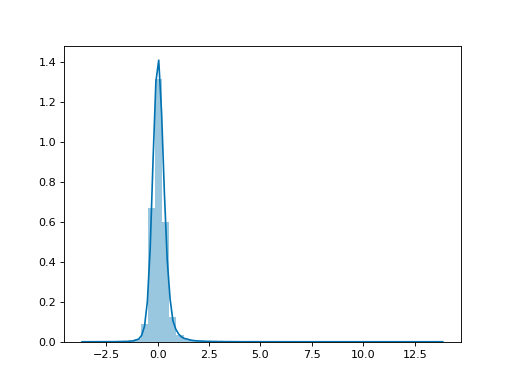

In [1608]:
pl.figure()
sns.distplot(zs.values.ravel())


In [1604]:
sns.distplot(bas_std.values.ravel())


In [1632]:
# Select metric
response_metric = 'zscore'

# Get response metric for each trial
trial_metrics = util.get_trial_metrics(traces, labels, response_type=response_metric, nframes_post_onset=None)
print(trial_metrics.shape)


(1635, 271)


In [244]:
# Get cells that are visually responsive, if manual ROIs
run_name = 'combined_%s_static' % stimulus
responsive_cells, n_cells_total = util.get_responsive_cells(animalid, session, fov, run=run_name, traceid=traceid,
                                                       responsive_test=responsive_test, 
                                                       responsive_thr=responsive_thr, 
                                                       n_stds=n_stds)
print("%i out of %i cells passed responsive test metric" % (len(responsive_cells), n_cells_total))

-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1109ae_traces001_920e9d_traces001_8dceeb_traces001_7c7a76_traces001_cc90dc_traces001_344475/summary_stats/ROC/roc_results.pkl']
...loading stats
loaded
122 out of 533 cells passed responsive test metric


In [1609]:
# Select subset of data (responsive cells only)
# trial_means = trial_means[responsive_cells]

# And zscore values (zscore within cell)
#zscored_ = (trial_means[responsive_cells] - trial_means[responsive_cells].mean())/trial_means[responsive_cells].std()
#abs_zscored = zscored_.abs()


# Add config for each trial
#abs_zscored['config'] = [c[0] for c in labels.groupby(['trial'])['config'].unique().reset_index()['config']]

trial_df = zs[responsive_cells].copy()
trial_df['config'] = [c[0] for c in labels.groupby(['trial'])['config'].unique().reset_index()['config']]


In [246]:
trial_df.head()

11        15        19        20        22        24        26  \
0  0.093244  0.067267 -0.070457  0.420740  0.554701  0.554449  1.072284   
1  0.452293 -0.048627  0.652559 -0.384105 -0.305984  0.416120 -0.161138   
2  0.839875  0.198550  1.007333 -0.340037  0.222362  0.397088  0.260740   
3 -0.117511  0.390324 -0.056692 -0.142822 -0.335350  0.503108  0.122299   
4  1.111808 -0.037093  0.122484  0.142631  0.435942  0.107734  0.001158   

         28        31        32    ...           499       510       511  \
0  0.363485 -0.456175  0.159314    ...      0.058274  0.027035  0.393724   
1  0.498303  0.162296  0.133302    ...      0.443036 -0.533564 -0.125271   
2 -0.237897  0.313691  0.532288    ...      0.260866  0.138730 -0.005095   
3  0.506372 -0.138673  0.066800    ...      0.188773  0.321236 -0.306836   
4  0.212414  0.349253  0.110868    ...     -0.175156  0.678096 -0.247233   

        513       518       519       523       530       531     config  
0  0.505235  0.399359  0.309410  1.197310  0.491491  0.013455  config035  
1  0.301647  0.096899 -0.029703  0.681489  0.189586  0.049276  config045  
2  0.213164  0.225010  0.033038  0.479609  0.794625  0.277961  config030  
3 -0.148342  0.421731 -0.174072  0.256811  0.234689  0.252427  config050  
4 -0.169869  0.146188  0.082894  0.369849 -0.276049  0.352064  config002  

[5 rows x 123 columns]

In [247]:
# pl.figure()
# sns.distplot(trial_df[responsive_cells[0]])
# sns.distplot(trial_df[responsive_cells[2]])



## Select stim conditions

In [1633]:
if stimulus == 'gratings':
    # Similarity by orientation
    curr_sf = 0.1
    curr_speed = 10
    curr_size = sdf['size'].min()
    curr_sdf = sdf[(sdf['sf']==curr_sf) & (sdf['speed']==curr_speed) & (sdf['size']==curr_size)].copy()
else:
    #curr_size = 30.
    curr_sdf = sdf[(sdf['morphlevel']!=-1) & (sdf['morphlevel']!=53)]
#                   & (sdf['size']==curr_size)].copy()

curr_sdf

color morphlevel   object  size stimtype xpos ypos yrot
config006                0  Blob_N1  10.0    image   30   -5    0
config007                0  Blob_N1  20.0    image   30   -5    0
config008                0  Blob_N1  30.0    image   30   -5    0
config009                0  Blob_N1  40.0    image   30   -5    0
config010                0  Blob_N1  50.0    image   30   -5    0
config011               14  morph14  10.0    image   30   -5    0
config012               14  morph14  20.0    image   30   -5    0
config013               14  morph14  30.0    image   30   -5    0
config014               14  morph14  40.0    image   30   -5    0
config015               14  morph14  50.0    image   30   -5    0
config016               27  morph27  10.0    image   30   -5    0
config017               27  morph27  20.0    image   30   -5    0
config018               27  morph27  30.0    image   30   -5    0
config019               27  morph27  40.0    image   30   -5    0
config020               27  morph27  50.0    image   30   -5    0
config021               40  morph40  10.0    image   30   -5    0
config022               40  morph40  20.0    image   30   -5    0
config023               40  morph40  30.0    image   30   -5    0
config024               40  morph40  40.0    image   30   -5    0
config025               40  morph40  50.0    image   30   -5    0
config031               66  morph66  10.0    image   30   -5    0
config032               66  morph66  20.0    image   30   -5    0
config033               66  morph66  30.0    image   30   -5    0
config034               66  morph66  40.0    image   30   -5    0
config035               66  morph66  50.0    image   30   -5    0
config036               79  morph79  10.0    image   30   -5    0
config037               79  morph79  20.0    image   30   -5    0
config038               79  morph79  30.0    image   30   -5    0
config039               79  morph79  40.0    image   30   -5    0
config040               79  morph79  50.0    image   30   -5    0
config041               92  morph92  10.0    image   30   -5    0
config042               92  morph92  20.0    image   30   -5    0
config043               92  morph92  30.0    image   30   -5    0
config044               92  morph92  40.0    image   30   -5    0
config045               92  morph92  50.0    image   30   -5    0
config046              106  Blob_N2  10.0    image   30   -5    0
config047              106  Blob_N2  20.0    image   30   -5    0
config048              106  Blob_N2  30.0    image   30   -5    0
config049              106  Blob_N2  40.0    image   30   -5    0
config050              106  Blob_N2  50.0    image   30   -5    0

In [1634]:
# Group by "similarity"
if stimulus == 'gratings':
    group_a = curr_sdf[curr_sdf['ori']<180.]
    group_b = curr_sdf[curr_sdf['ori']>=180.]
else:
    group_a = curr_sdf[curr_sdf['morphlevel']<53]
    group_b = curr_sdf[curr_sdf['morphlevel']>53]
    
print(group_a.shape, group_b.shape)
curr_conditions = np.union1d(group_a.index.tolist(), group_b.index.tolist())
len(curr_conditions)

((20, 8), (20, 8))


40

In [1635]:
# Select subset of trials where cond shown
curr_trials = trial_df[trial_df['config'].isin(curr_conditions)].copy()
print(curr_trials.shape)

(1200, 48)


In [1636]:
# Assign same/different label for each trial
# same_flags = [None]
# for ti in np.arange(1, curr_trials.shape[0]):
#     curr_cfg = curr_trials.iloc[ti]['config']
#     group_id = [1 if curr_cfg in group_a.index.tolist() else 0 for curr_cfg in curr_trials['config']]
    #prev_group_id = 'a' if curr_trials.iloc[ti-1]['config'] in group_a.index.tolist() else 'b'
    #same_group = 1 if group_id==prev_group_id else 0
    #same_flags.append(same_group)
curr_trials['group_id'] = [1 if curr_cfg in group_a.index.tolist() else 0 for curr_cfg in curr_trials['config']]

# Group responses by A or B
responses_by_group = curr_trials.copy()
responses_by_group = responses_by_group.drop('config', 1)


In [1637]:
# Get change in response relative to previous trial
delta_responses = responses_by_group - responses_by_group.shift() # subtract each row from subsequent row
delta_responses = delta_responses.drop(delta_responses.index[0])  # drop first row (nan)
delta_responses['novel'] = [f!=0 for f in delta_responses['group_id']] # flag whether same or diff

In [1638]:
# Get average response by novel or same group
mean_novel = delta_responses.drop('group_id', 1).groupby(['novel']).mean().T
#mean_novel = delta_responses.groupby(['novel']).mean().T
mean_novel.head()

novel     False     True 
1     -0.940256  0.939711
3     -0.134077 -0.076033
6      0.114806 -0.093460
7     -0.461862  0.354823
11    -2.220770  2.107921

In [1639]:
sns.set_palette('colorblind')

<IPython.core.display.Javascript object>


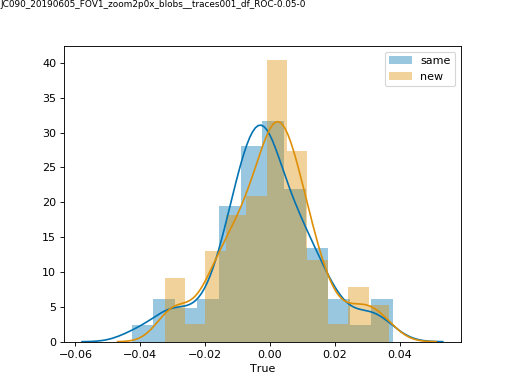

('/n/coxfs01/julianarhee/aggregate-visual-areas/stimulus_history', 'same-v-new_distn_1-back_zscore-responses_all-sizes__id_JC090_20190605_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0')


In [264]:
fig, ax = pl.subplots()

sns.distplot(mean_novel[0], label='same', ax=ax)
sns.distplot(mean_novel[1], label='new', ax=ax)
pl.legend()

putils.label_figure(fig, fig_id)
figname = 'same-v-new_distn_1-back_%s-responses_all-sizes__id_%s' % (response_metric, fig_id)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print(outdir, figname)

In [267]:
li_blobs


animalid experiment            fov   session visual_area  fovnum
16     JC091      blobs  FOV1_zoom2p0x  20191008          Li       1
22     JC091      blobs  FOV1_zoom2p0x  20190607          Li       1
26     JC091      blobs  FOV1_zoom2p0x  20190614          Li       1
30     JC091      blobs  FOV1_zoom2p0x  20190606          Li       1
35     JC091      blobs  FOV1_zoom2p0x  20190602          Li       1
54     JC090      blobs  FOV1_zoom2p0x  20190605          Li       1
58     JC099      blobs  FOV1_zoom2p0x  20190612          Li       1
62     JC099      blobs  FOV1_zoom2p0x  20190617          Li       1
66     JC099      blobs  FOV1_zoom2p0x  20190609          Li       1
112    JC117      blobs  FOV1_zoom2p0x  20191105          Li       1
118    JC120      blobs  FOV1_zoom2p0x  20191111          Li       1
130    JC076      blobs  FOV1_zoom2p0x  20190502          Li       1
132    JC076      blobs  FOV1_zoom2p0x  20190422          Li       1
194    JC113      blobs  FOV1_zoom2p0x  20191018          Li       1

In [289]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

In [1640]:
# li_blobs = sdata[(sdata['visual_area']=='Li') & (sdata['experiment']=='blobs')]
# li_gratings = sdata[(sdata['visual_area']=='Li') & (sdata['experiment']=='gratings')]

# Select stimulus type and get datasets
stimulus = 'blobs'

if stimulus=='blobs':
    li_datasets = sdata[(sdata['visual_area']=='Li') & (sdata['experiment']=='blobs')].copy()
else:
    li_datasets = sdata[(sdata['visual_area']=='Li') & (sdata['experiment']=='gratings')].copy()

li_datasets = sdata[(sdata['visual_area']=='Li') & (sdata['experiment']=='blobs')].copy()


In [1644]:
# Select metric and load data
response_metric = 'dff'

DATA = aggr.load_aggregate_data(stimulus, traceid=traceid, response_type=response_metric, epoch='stimulus',
                                responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)


...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/blobs_traces001-dff_ROC-thr-0.05_stimulus.pkl


# Group by similarity X

In [1645]:
# grouper = 'morphlevel'

# abs_value = False

# missing = []
# dfs = []
# for (animalid, session, fovnum), g in li_datasets.groupby(['animalid', 'session', 'fovnum']):
#     data_str = '%s_%s_fov%i' % (session, animalid, fovnum)
#     fov = 'FOV%i_zoom2p0x' % fovnum

#     if data_str not in DATA.keys():
#         missing.append(data_str)
#         continue

#     rois = [r for r in DATA[data_str]['data'].columns if r!='config']
#     sdf = DATA[data_str]['sdf'].copy()
#     trial_df = DATA[data_str]['data'].copy()

#     # Select stimulus conditions # Group by "similarity"
#     if stimulus == 'gratings':
#         # Similarity by orientation
#         sdf_ex = sdf.copy()
#         group_a = sdf[sdf['ori']<180.].copy()
#         group_b = sdf[sdf['ori']>=180.].copy()
#     else:
#         # Exclude full-screen control trials
#         sdf_ex = sdf[sdf['morphlevel']!=-1].copy()
#         excluded_cfgs = sdf[sdf['morphlevel']==-1].index.tolist()

#         if grouper=='morphlevel':
#             # Exclude midpoint
#             excluded_mid_cfgs = sdf_ex[sdf_ex['morphlevel']==53].index.tolist()
#             group_a = sdf_ex[sdf_ex['morphlevel']<53].copy()
#             group_b = sdf_ex[sdf_ex['morphlevel']>53].copy()

#         elif grouper=='size':
#             # Exclude midpoint
#             excluded_mid_cfgs = sdf_ex[sdf_ex['size']==30].index.tolist()
#             group_a = sdf_ex[sdf_ex['size']<30].copy()
#             group_b = sdf_ex[sdf_ex['size']>30].copy()

#         # Exclude midpoint and control conds
#         excluded_cfgs.extend(excluded_mid_cfgs)


#     # get all conditions
#     included_cfgs = [c for c in sdf_ex.index.tolist() if c not in excluded_cfgs]
#     print("Similarity aggregated from %i conditions" % len(included_cfgs))

#     # Assign same/different label for each trial
#     trial_df['group_id'] = [100 for _ in np.arange(0, trial_df.shape[0])]

#     # Use large number to ID "excluded configs" (i.e.,exclude without messing up temporal order of trials)
#     incl_ixs = trial_df[trial_df['config'].isin(included_cfgs)].index.tolist()
#     trial_df['group_id'][incl_ixs] = [1 if curr_cfg in group_a.index.tolist() else 0 \
#                                          for curr_cfg in trial_df['config'][incl_ixs]]

#     # Group responses by A or B
#     responses_by_group = trial_df.drop('config', 1)

#     # Get change in response relative to previous trial
#     delta_responses = responses_by_group - responses_by_group.shift() # subtract each row from subsequent row
#     delta_responses = delta_responses.drop(delta_responses.index[0])  # drop first row (nan)

#     delta_responses['novel'] = [f!=0 for f in delta_responses['group_id']] # flag whether same or diff
#     delta_responses['config'] = trial_df['config'][1:]
#     delta_responses = delta_responses.rename(columns={'group_id': 'id_diff'})
#     delta_responses['group_id'] = trial_df['group_id'][1:]

#     # Remove trials where full-screen stimulus shown on previous/subsequent trial
#     diff_from_prev = delta_responses[delta_responses['id_diff'].abs().isin([0, 1])]
#     diff_from_prev[grouper] = [sdf[grouper][c] for c in diff_from_prev['config']]

#     # Get mean response for each neuron for "novel" and "same"
#     # mean_novel_df = diff_from_prev.drop('group_id', 1).abs().groupby(['novel']).apply(np.mean).unstack()
#     # mean_novel_df = diff_from_prev.drop('group_id', 1).groupby(['novel']).apply(np.mean).unstack()

#     mean_novel_df = diff_from_prev.groupby(['novel'])[rois].mean().unstack()
#     mean_novel_df = mean_novel_df.reset_index().rename(columns={0: response_metric,
#                                                                'level_0': 'rid'})
#     #mean_novel_df = mean_novel_df[mean_novel_df['rid']!='novel']

#     # add to df
#     mean_novel_df['data_id'] = [data_str for _ in np.arange(0, len(mean_novel_df))]
#     dfs.append(mean_novel_df)

# mean_novel_all = pd.concat(dfs, axis=0)
# print(mean_novel_all.head())

# print("missing datasets:")
# print(missing)

# means_by_dset = mean_novel_all[['data_id','novel', response_metric]].groupby(['data_id','novel']).mean().reset_index()
# means_by_dset.head()

In [1646]:
grouper = 'morphlevel'

abs_value = False

missing = []
dfs = []
for (animalid, session, fovnum), g in li_datasets.groupby(['animalid', 'session', 'fovnum']):
    data_str = '%s_%s_fov%i' % (session, animalid, fovnum)
    fov = 'FOV%i_zoom2p0x' % fovnum

    if data_str not in DATA.keys():
        missing.append(data_str)
        continue
        
    rois = [r for r in DATA[data_str]['data'].columns if r!='config']
    sdf = DATA[data_str]['sdf'].copy()
    trial_df = DATA[data_str]['data'].copy()

    # Select stimulus conditions # Group by "similarity"
    if stimulus == 'gratings':
        # Similarity by orientation
        sdf_ex = sdf.copy()
        group_a = sdf[sdf['ori']<180.].copy()
        group_b = sdf[sdf['ori']>=180.].copy()
    else:
        # Exclude full-screen control trials
        sdf_ex = sdf[sdf['morphlevel']!=-1].copy()
        excluded_cfgs = sdf[sdf['morphlevel']==-1].index.tolist()

        if grouper=='morphlevel':
            # Exclude midpoint
            excluded_mid_cfgs = sdf_ex[sdf_ex['morphlevel']==53].index.tolist()
            group_a = sdf_ex[sdf_ex['morphlevel']<53].copy()
            group_b = sdf_ex[sdf_ex['morphlevel']>53].copy()

        elif grouper=='size':
            # Exclude midpoint
            excluded_mid_cfgs = sdf_ex[sdf_ex['size']==30].index.tolist()
            group_a = sdf_ex[sdf_ex['size']<30].copy()
            group_b = sdf_ex[sdf_ex['size']>30].copy()

        # Exclude midpoint and control conds
        excluded_cfgs.extend(excluded_mid_cfgs)


    # get all conditions
    included_cfgs = [c for c in sdf_ex.index.tolist() if c not in excluded_cfgs]
    incl_ixs = trial_df[trial_df['config'].isin(included_cfgs)].index.tolist()
    print("Similarity aggregated from %i conditions" % len(included_cfgs))

    # Assign same/different label for each trial
    # Use large number to ID "excluded configs" (i.e.,exclude without messing up temporal order of trials)
    trial_df['group_id'] = [100 for _ in np.arange(0, trial_df.shape[0])]
    trial_df['group_id'][incl_ixs] = [1 if curr_cfg in group_a.index.tolist() else 0 \
                                         for curr_cfg in trial_df['config'][incl_ixs]]

    # Group responses by A or B
    responses_by_group = trial_df.drop('config', 1)

    # Get change in response relative to previous trial
    delta_responses = responses_by_group - responses_by_group.shift() # subtract each row from subsequent row
    delta_responses = delta_responses.drop(delta_responses.index[0])  # drop first row (nan)
    delta_responses = delta_responses.rename(columns={'group_id': 'id_diff'}) # rename prev-subtracted values (now, diff bw ID groups)
    delta_responses['novel'] = delta_responses['id_diff'].abs()==1 # flag whether same or diff
    delta_responses['config'] = trial_df['config'][1:] # add stim condition of current trial
    delta_responses['group_id'] = trial_df['group_id'][1:] # add original similarity group ID

    # Remove trials where full-screen stimulus shown on previous/subsequent trial
    # diff_from_prev = delta_responses[delta_responses['id_diff'].abs().isin([0, 1])]
    excl_ixs = trial_df[trial_df['group_id']==100].index.tolist() # exclude trials w/ exclude_cond presented
    excl_ixs.extend([i+1 for i in excl_ixs]) # also remove all trials occurring after an exclude_cond
    excl_ixs = np.unique(excl_ixs)
    remove_ctrl_ixs = [i for i in delta_responses.index.tolist() if i not in excl_ixs]
    diff_from_prev = delta_responses.loc[remove_ctrl_ixs]
    diff_from_prev['morphlevel'] = [sdf['morphlevel'][c] for c in diff_from_prev['config']]

    mean_by_cond = diff_from_prev.groupby(['novel', 'morphlevel'])[rois].mean()
    mean_by_cond = mean_by_cond.T.unstack().reset_index().rename(columns={'level_2': 'roi', 0: response_metric})
    mean_by_cond['data_id'] = [data_str for _ in np.arange(0, len(mean_by_cond))]
    
    dfs.append(mean_by_cond)

mean_novel_all = pd.concat(dfs, axis=0)
print(mean_novel_all.head())

print("missing datasets:")
print(missing)

means_by_dset = mean_novel_all[['data_id','novel', response_metric]].groupby(['data_id','novel']).mean().reset_index()
means_by_dset.head()

Similarity aggregated from 40 conditions


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Similarity aggregated from 40 conditions
Similarity aggregated from 40 conditions
Similarity aggregated from 40 conditions
Similarity aggregated from 40 conditions
Similarity aggregated from 40 conditions
Similarity aggregated from 40 conditions
Similarity aggregated from 40 conditions
Similarity aggregated from 40 conditions
Similarity aggregated from 40 conditions
Similarity aggregated from 40 conditions
Similarity aggregated from 40 conditions
Similarity aggregated from 40 conditions
   novel  morphlevel  roi       dff              data_id
0  False           0    5  0.006746  20190422_JC076_fov1
1  False           0   32  0.002269  20190422_JC076_fov1
2  False           0   34 -0.002249  20190422_JC076_fov1
3  False           0   41 -0.001036  20190422_JC076_fov1
4  False           0   47 -0.000886  20190422_JC076_fov1
missing datasets:
['20191008_JC091_fov1']


data_id  novel       dff
0  20190422_JC076_fov1  False -0.000436
1  20190422_JC076_fov1   True  0.000030
2  20190502_JC076_fov1  False  0.000122
3  20190502_JC076_fov1   True -0.000556
4  20190602_JC091_fov1  False  0.001095

In [1577]:
uncertain_datasets = ['20191111_JC120_fov1']


<IPython.core.display.Javascript object>


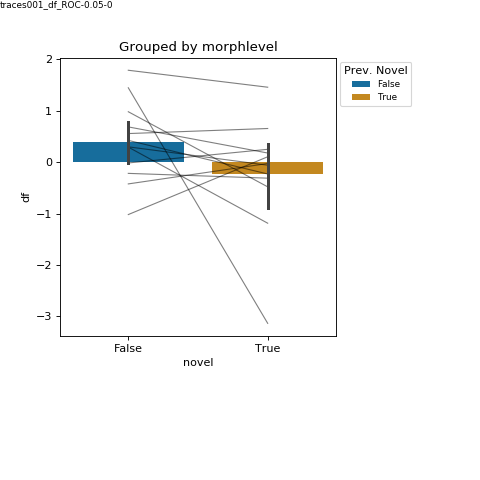

In [1623]:
exclude_uncertain = True
if exclude_uncertain:
    curr_datasets = [d for d in means_by_dset['data_id'].unique() if d not in uncertain_datasets]
    meandf = means_by_dset[means_by_dset['data_id'].isin(curr_datasets)].copy()
else:
    meandf = means_by_dset.copy()
dset_str = 'exclude_uncertain' if exclude_uncertain else ''

fig, ax = pl.subplots(figsize=(6,6)) #, dpi=dpi)
fig.patch.set_alpha(1)
ax.patch.set_alpha(1)
aix=0
offset = .25 #.25
plot_each = True
label_each=False
color = None if label_each else 'k'

label_str = 'label-each-fov' if label_each else ''
lw = 2 if label_each else 1

#for si, sz in enumerate(sizes):
a_vals = meandf[meandf['novel']==False].sort_values(by='data_id')[response_metric].values
b_vals = meandf[meandf['novel']==True].sort_values(by='data_id')[response_metric].values

sns.barplot("novel", response_metric, data=meandf, 
            hue='novel', dodge=False, #ci='sd',
             zorder=0,
            ax=ax)

x1, x2 = ax.get_xticks()

if plot_each:
    sns.set_palette('colorblind')
    by_dset = [(a, b) for a, b in zip(a_vals, b_vals)]
    d_ids = plotdf.sort_values(by='data_id')['data_id'].unique()

    for pi, (p, d) in enumerate(zip(by_dset, d_ids)):
        if exclude_uncertain and d in uncertain_datasets:
            continue
        label = d if si==4 and label_each else None
        ax.plot([x1, x2], p, 
                marker=None, label=label, color=color, #area_colors[visual_area], 
                alpha=.5, lw=lw,  zorder=0)


pl.subplots_adjust(right=0.7, bottom=0.3)
ax.legend(bbox_to_anchor=(1, 1), fontsize=8, title='Prev. Novel')
ax.set_title('Grouped by %s' % grouper)

putils.label_figure(fig, base_fig_id)
figname = 'avg-by-dataset_grouper-%s_same-v-novel_all-trials_excl-fullscreen_%s_%s' % (grouper, dset_str, label_str)
#pl.savefig(os.path.join(outdir, '%s.png' % figname))
#print(outdir, figname)


## Some stats

In [1592]:
exclude_uncertain = True
if exclude_uncertain:
    curr_datasets = [d for d in means_by_dset['data_id'].unique() if d not in uncertain_datasets]
    meandf = means_by_dset[means_by_dset['data_id'].isin(curr_datasets)].copy()
else:
    meandf = means_by_dset.copy()

v1 = meandf[meandf['novel']==True].sort_values(by='data_id')[response_metric]
v2 = meandf[meandf['novel']==False].sort_values(by='data_id')[response_metric]
d_ids = meandf[meandf['novel']==True].sort_values(by='data_id')['data_id']

shapiro_W, shapiro_pval = spstats.shapiro(v1)
print("Shapiro normality test for novel (W=%.2f, p=%.3f)" % (shapiro_W, shapiro_pval))

shapiro_W, shapiro_pval = spstats.shapiro(v2)
print("Shapiro normality test for same (W=%.2f, p=%.3f)" % (shapiro_W, shapiro_pval))

t_stat, t_pval = spstats.ttest_rel(v1, v2)
print("Paired t-ttest (%.2f, p=%.3f, df=%i)" % (t_stat, t_pval, len(v1)-1))

diffs = pd.DataFrame({'novel': v1.values, 'same': v2.values, 'data_id': d_ids.values,
                     'difference': v1.values-v2.values})

w, p = spstats.wilcoxon(diffs['difference'].values)
print(w, p)



Shapiro normality test for novel (W=0.82, p=0.011)
Shapiro normality test for same (W=0.92, p=0.257)
Paired t-ttest (-0.38, p=0.712, df=12)
(37.0, 0.55249333600160622)


<IPython.core.display.Javascript object>


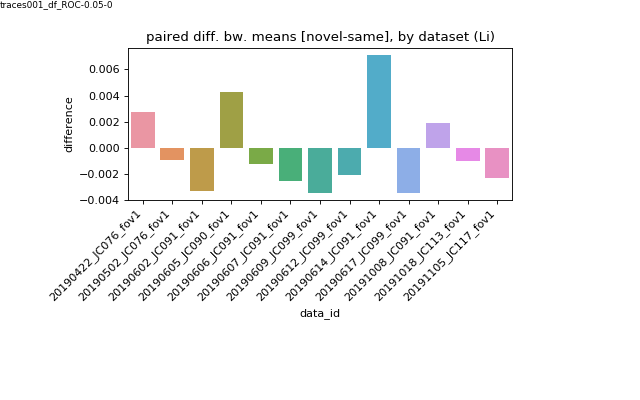

In [1593]:
dset_str = 'exclude_uncertain' if exclude_uncertain else ''

fig, ax = pl.subplots(figsize=(8,5))
fig.patch.set_alpha(1)
sns.barplot(x='data_id', y='difference', data=diffs, ax=ax)
pl.xticks(rotation=45, horizontalalignment='right')
ax.set_title('paired diff. bw. means [novel-same], by dataset (Li)')
pl.subplots_adjust(bottom=0.5, left=0.2, right=0.8)

putils.label_figure(fig, base_fig_id)
figname = 'paired_diff_mean_novel_minus_mean_same_grouper-%s_%s_by_dataset_Li_%s' % (grouper, response_metric, dset_str)
#pl.savefig(os.path.join(outdir, '%s.png' % figname))
#print(outdir, figname)

In [1367]:
exclude_uncertain = True
if exclude_uncertain:
    curr_datasets = [d for d in mean_novel_all['data_id'].unique() if d not in uncertain_datasets]
    meandf = mean_novel_all[mean_novel_all['data_id'].isin(curr_datasets)].copy()
else:
    meandf = mean_novel_all.copy()

v1 = meandf[meandf['novel']==True].sort_values(by='data_id')[response_metric]
v2 = meandf[meandf['novel']==False].sort_values(by='data_id')[response_metric]
d_ids = meandf[meandf['novel']==True].sort_values(by='data_id')['data_id']

shapiro_W, shapiro_pval = spstats.shapiro(v1)
print("Shapiro normality test for novel (W=%.2f, p=%.3f)" % (shapiro_W, shapiro_pval))

shapiro_W, shapiro_pval = spstats.shapiro(v2)
print("Shapiro normality test for same (W=%.2f, p=%.3f)" % (shapiro_W, shapiro_pval))

t_stat, t_pval = spstats.ttest_rel(v1, v2)
print("Paired t-ttest (%.2f, p=%.3f, df=%i)" % (t_stat, t_pval, len(v1)-1))

diffs = pd.DataFrame({'novel': v1.values, 'same': v2.values, 'data_id': d_ids.values,
                     'difference': v1.values-v2.values})

w, p = spstats.wilcoxon(diffs['difference'].values)
print(w, p)



Shapiro normality test for novel (W=0.62, p=0.000)
Shapiro normality test for same (W=0.47, p=0.000)
Paired t-ttest (5.89, p=0.000, df=1164)
(272657.0, 5.6133223515710126e-09)


In [1580]:
means_by_dset

data_id  novel       dff
0   20190422_JC076_fov1  False -0.001955
1   20190422_JC076_fov1   True  0.000786
2   20190502_JC076_fov1  False -0.000742
3   20190502_JC076_fov1   True -0.001696
4   20190602_JC091_fov1  False  0.003143
5   20190602_JC091_fov1   True -0.000172
6   20190605_JC090_fov1  False -0.004427
7   20190605_JC090_fov1   True -0.000164
8   20190606_JC091_fov1  False  0.001619
9   20190606_JC091_fov1   True  0.000377
10  20190607_JC091_fov1  False  0.001900
11  20190607_JC091_fov1   True -0.000643
12  20190609_JC099_fov1  False  0.001506
13  20190609_JC099_fov1   True -0.001988
14  20190612_JC099_fov1  False  0.002171
15  20190612_JC099_fov1   True  0.000041
16  20190614_JC091_fov1  False -0.003234
17  20190614_JC091_fov1   True  0.003886
18  20190617_JC099_fov1  False  0.009231
19  20190617_JC099_fov1   True  0.005779
20  20191008_JC091_fov1  False -0.001548
21  20191008_JC091_fov1   True  0.000304
22  20191018_JC113_fov1  False -0.000170
23  20191018_JC113_fov1   True -0.001224
24  20191105_JC117_fov1  False  0.000694
25  20191105_JC117_fov1   True -0.001639
26  20191111_JC120_fov1  False -0.016487
27  20191111_JC120_fov1   True  0.010142

<IPython.core.display.Javascript object>


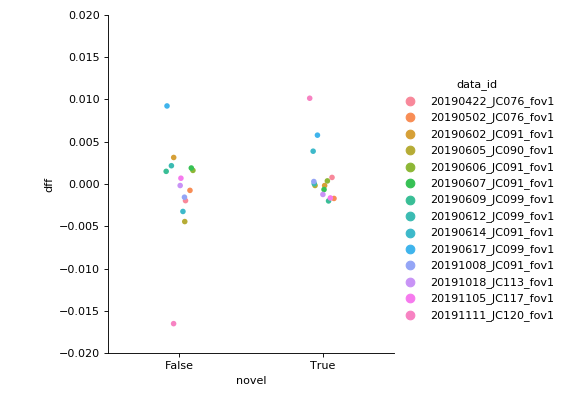

(-0.02, 0.02)

In [1581]:
sns.catplot(x='novel', y=response_metric, hue='data_id', data=means_by_dset,
            
           jitter=True)
pl.ylim([-0.02, 0.02])

## Plot individual datasets

In [1582]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    # from: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    
    # cmap = mpl.cm.get_cmap('RdBu') #sns.diverging_palette(220, 20)
    # div_cmap = shiftedColorMap(cmap, midpoint=0)
    # mpl.cm.register_cmap("midmap", cmap)
    # cpal = sns.color_palette("midmap", n_colors=len(diffs))

    # sns.palplot(cpal)

    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    pl.register_cmap(cmap=newcmap)

    return newcmap

In [1583]:
# cmap = mpl.cm.get_cmap('RdBu_r') #sns.diverging_palette(220, 20)
# div_cmap = shiftedColorMap(cmap, midpoint=0)
# mpl.cm.register_cmap("midmap", cmap)

In [1584]:

# fig, ax = pl.subplots(figsize=(10,10), dpi=150)

# #fig, ax = pl.subplots(figsize=(8,5))
# v1 = g[g['novel']==True].sort_values(by='rid')[response_metric] 
# v2 = g[g['novel']==False].sort_values(by='rid')[response_metric] 
# r_ids = g[g['novel']==True].sort_values(by='rid')['rid']
# ylabel = 'new-same (%s)' % response_metric
# diffs = pd.DataFrame({'novel': v1.values, 'same': v2.values, 'roi': r_ids.values,
#                       ylabel: v1.values-v2.values})
# diffs = diffs.sort_values(by=[ylabel]).reset_index(drop=True)

# cpal = sns.color_palette("midmap", n_colors=len(diffs))
# sns.barplot(ylabel, diffs.index, data=diffs, ax=ax, orient='h', palette=cpal)

# #ax.set_title('paired diff. bw. means [novel-same], by dataset (Li)')
# pl.subplots_adjust(bottom=0.5, left=0.2, right=0.8)


In [1586]:
ylabel = 'new-same (%s)' % response_metric

diff_df = []
for data_id, g in mean_novel_all.groupby(['data_id']):

    print("-----------------------------")
    print("%s" % data_id)
    
    v1 = g[g['novel']==True].sort_values(by='roi')[response_metric]
    v2 = g[g['novel']==False].sort_values(by='roi')[response_metric]
    r_ids = g[g['novel']==True].sort_values(by='roi')['roi']


    shapiro_W, shapiro_pval = spstats.shapiro(v1)
    print("Shapiro normality test for novel (W=%.2f, p=%.3f)" % (shapiro_W, shapiro_pval))

    shapiro_W, shapiro_pval = spstats.shapiro(v2)
    print("Shapiro normality test for same (W=%.2f, p=%.3f)" % (shapiro_W, shapiro_pval))

    t_stat, t_pval = spstats.ttest_rel(v1, v2)
    print("Paired t-ttest (%.2f, p=%.3f, df=%i)" % (t_stat, t_pval, len(v1)-1))

    diffs = pd.DataFrame({'novel': v1.values, 'same': v2.values, 'roi': r_ids.values,
                          ylabel: v1.values-v2.values})
    
    w, p = spstats.wilcoxon(diffs[ylabel].values)
    print(w, p)
    
    diffs['data_id'] = [data_id for _ in np.arange(0, len(diffs))]
    diff_df.append(diffs)
    
diff_df = pd.concat(diff_df, axis=0)
diff_df.head()

-----------------------------
20190422_JC076_fov1
Shapiro normality test for novel (W=0.58, p=0.000)
Shapiro normality test for same (W=0.81, p=0.000)
Paired t-ttest (1.16, p=0.248, df=631)
(90199.0, 0.032563686534179105)
-----------------------------
20190502_JC076_fov1
Shapiro normality test for novel (W=0.68, p=0.000)
Shapiro normality test for same (W=0.67, p=0.000)
Paired t-ttest (-0.43, p=0.665, df=479)
(51982.0, 0.059137294515496625)
-----------------------------
20190602_JC091_fov1
Shapiro normality test for novel (W=0.44, p=0.000)
Shapiro normality test for same (W=0.40, p=0.000)
Paired t-ttest (-1.22, p=0.224, df=1287)
(333975.0, 1.2564585588679374e-09)
-----------------------------
20190605_JC090_fov1
Shapiro normality test for novel (W=0.99, p=0.000)
Shapiro normality test for same (W=0.93, p=0.000)
Paired t-ttest (2.59, p=0.010, df=1127)
(295585.0, 0.037272850465117809)
-----------------------------
20190606_JC091_fov1
Shapiro normality test for novel (W=0.95, p=0.000)
Sha

new-same (dff)     novel  roi      same              data_id
0       -0.263323 -0.188193    5  0.075129  20190422_JC076_fov1
1       -0.094756 -0.139831    5 -0.045075  20190422_JC076_fov1
2       -0.245051 -0.171409    5  0.073642  20190422_JC076_fov1
3        0.072463 -0.002436    5 -0.074898  20190422_JC076_fov1
4        0.225231  0.225901    5  0.000670  20190422_JC076_fov1

In [1587]:
cmap = mpl.cm.get_cmap('RdBu_r') #sns.diverging_palette(220, 20)
div_cmap = shiftedColorMap(cmap, midpoint=0)
mpl.cm.register_cmap("midmap", cmap)

<IPython.core.display.Javascript object>


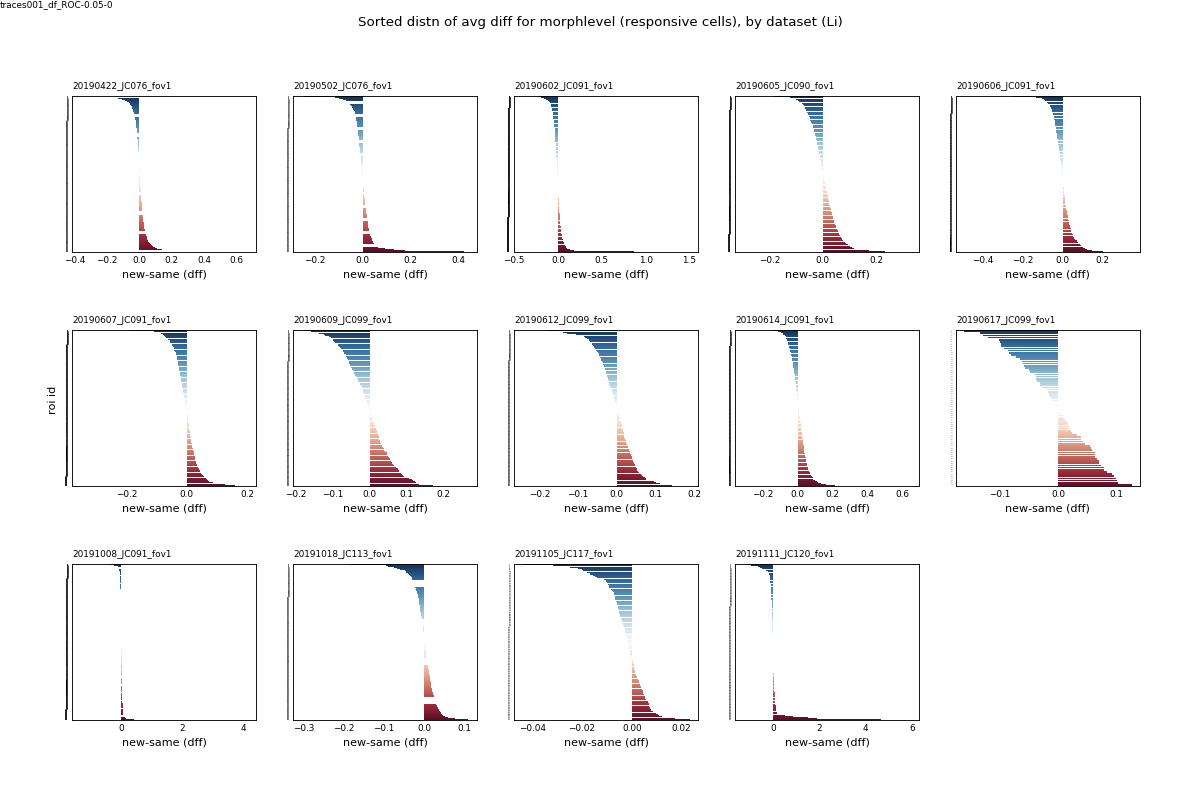

In [1588]:
nr=3
nc=5

fig, axn = pl.subplots(nr, nc, figsize=(15, 10), sharex=False)
fig.patch.set_alpha(1)

ai = 0
for data_id, diffs in diff_df.groupby(['data_id']):
    ax = axn.flat[ai]

    # Sort values by difference
    diffs = diffs.sort_values(by=[ylabel]).reset_index(drop=True)
    
    # Select colormap so that 0=midpoint
    cpal = sns.color_palette("midmap", n_colors=len(diffs))
    sns.barplot(ylabel, diffs.index, data=diffs, ax=ax, orient='h', palette=cpal)

    # Label stuff
    ax.tick_params(which='both', axis='y', rotation=0, labelsize=0, length=0)
    ax.tick_params(which='both', axis='x', rotation=0, labelsize=8, length=0)
    ax.set_title(data_id, loc='left', fontsize=8)
    ai+=1


for ii in np.arange(ai, nr*nc):
    axn.flat[ii].axis('off')
pl.subplots_adjust(bottom=0.1, left=0.06, right=0.95, wspace=0.2, hspace=0.5)

# fig.text(0.5, 0.04, '%s' % ylabel, ha='center')
fig.text(0.04, 0.5, 'roi id', va='center', rotation='vertical')

pl.suptitle('Sorted distn of avg diff for %s (responsive cells), by dataset (Li)' % grouper)

putils.label_figure(fig, base_fig_id)
#pl.savefig(os.path.join(outdir, 'sorted_distn_%s_differences_novel_minus_same_zeroed_cmap.png' % grouper))

<IPython.core.display.Javascript object>


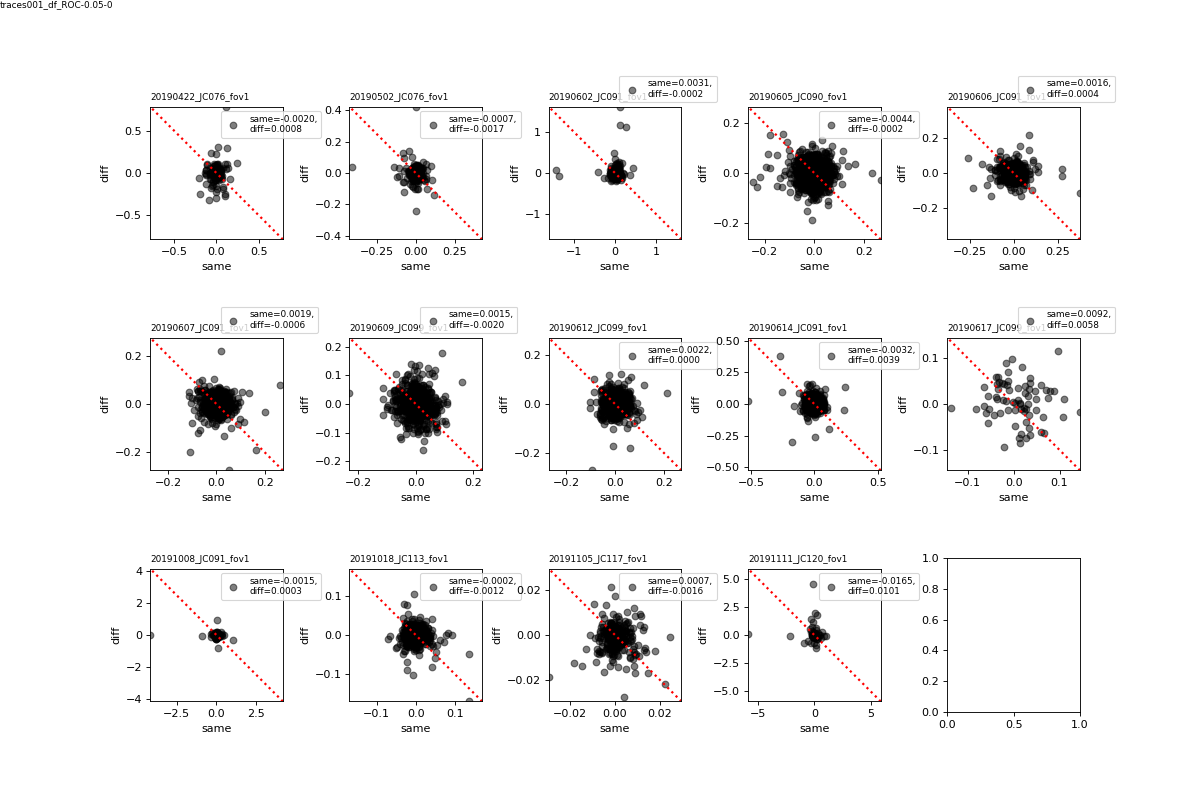

In [1589]:
nr=3
nc=5

fig, axn = pl.subplots(nr, nc, figsize=(15, 10), sharex=False)
fig.patch.set_alpha(1)

ai = 0
for data_id, g in mean_novel_all.groupby(['data_id']):
    ax = axn.flat[ai]
    v1 = g[g['novel']==False][response_metric].values
    v2 = g[g['novel']==True][response_metric].values
    
    #minv = min([v1.min(), v2.min()])
    maxv = max([abs(v1).max(), abs(v2).max()]) #v1.max(), v2.max()])
    minv = -maxv
    
    annot_str = 'same=%.4f,\ndiff=%.4f' % (v1.mean(), v2.mean())
    ax.scatter(v1, v2, alpha=0.5, color='k', label=annot_str)
    ax.legend(fontsize=8, bbox_to_anchor=(0.5, 1.))
    ax.set_aspect('equal')
    ax.set_ylim([minv, maxv])
    ax.set_xlim([minv, maxv])
    ax.set_xlabel('same')
    ax.set_ylabel('diff')
    ax.set_title(data_id, loc='left', fontsize=8)
    ax.plot([maxv, minv], [minv, maxv], lw=2, ls=':', color='r')
    ai+=1

pl.subplots_adjust(wspace=0.5,hspace=0.5)

putils.label_figure(fig, base_fig_id)
figname = 'avgs_by_rois_same_v_diff_trials__by_dataset'
#pl.savefig(os.path.join(outdir, '%s.png' % figname))

In [1412]:
means_by_dset.head()

data_id  novel       dff
0  20190422_JC076_fov1  False -0.001738
1  20190422_JC076_fov1   True  0.000787
2  20190502_JC076_fov1  False  0.000460
3  20190502_JC076_fov1   True -0.003177
4  20190602_JC091_fov1  False -0.000101

In [1464]:
group_a

color morphlevel   object  size stimtype xpos ypos yrot
config006                0  Blob_N1  10.0    image   30   -5    0
config007                0  Blob_N1  20.0    image   30   -5    0
config008                0  Blob_N1  30.0    image   30   -5    0
config009                0  Blob_N1  40.0    image   30   -5    0
config010                0  Blob_N1  50.0    image   30   -5    0
config011               14  morph14  10.0    image   30   -5    0
config012               14  morph14  20.0    image   30   -5    0
config013               14  morph14  30.0    image   30   -5    0
config014               14  morph14  40.0    image   30   -5    0
config015               14  morph14  50.0    image   30   -5    0
config016               27  morph27  10.0    image   30   -5    0
config017               27  morph27  20.0    image   30   -5    0
config018               27  morph27  30.0    image   30   -5    0
config019               27  morph27  40.0    image   30   -5    0
config020               27  morph27  50.0    image   30   -5    0
config021               40  morph40  10.0    image   30   -5    0
config022               40  morph40  20.0    image   30   -5    0
config023               40  morph40  30.0    image   30   -5    0
config024               40  morph40  40.0    image   30   -5    0
config025               40  morph40  50.0    image   30   -5    0

In [1610]:
zs.head()

0         1         2         3         4         5         6    \
1  1.240897 -0.043132  0.378681  0.763010  0.482932 -0.106027  1.611808   
2  0.674484  0.008388  0.008517  0.265388 -0.167399  0.753421  0.491625   
3 -0.940440 -0.059453  0.088571 -0.063819 -0.259930 -0.150655 -0.083547   
4  1.591585  0.312483  0.353171  0.386484  0.360642  0.120012  0.772742   
5 -0.344237  0.252186  0.079268  0.216493 -0.097953  0.727484  0.118658   

        7         8         9      ...          261       262       263  \
1  0.485525 -0.363405  0.878476    ...     1.221473 -0.671135  0.122214   
2  0.418718  0.042124  0.627586    ...    -0.156007 -0.347410  0.185338   
3 -0.296073  0.137302 -0.174409    ...    -0.208693  0.294582  0.297852   
4  0.132719 -0.161126  0.828407    ...     0.329449 -0.493306  0.227082   
5 -0.120700  0.011433  0.298390    ...     0.439104  0.062576  0.149386   

        264       265       266       267       268       269       270  
1  0.143618  0.774813 -1.279776  0.635763  0.700310  0.487568  0.466712  
2  0.259295  0.191992 -0.696648  0.122155 -0.165700  0.272610 -0.211869  
3 -0.371103  0.301779 -0.084722  0.576739 -0.426500  0.516917  0.234880  
4 -0.164610  0.687933 -0.504184  0.602624  0.095068  0.048417  0.016944  
5  0.203017  0.985545  0.518969  0.402163 -0.404727 -0.512573  0.198448  

[5 rows x 271 columns]

In [1611]:
grouper = 'morphlevel'

session = '20190605'
animalid = 'JC090'
fovnum = 1

data_str = '%s_%s_fov%i' % (session, animalid, fovnum)
fov = 'FOV%i_zoom2p0x' % fovnum

rois = [r for r in DATA[data_str]['data'].columns if r!='config']
sdf = DATA[data_str]['sdf'].copy()
# trial_df = DATA[data_str]['data'].copy()

trial_df = zs.copy()
trial_df['config'] = DATA[data_str]['data']['config'].copy()


# Select stimulus conditions # Group by "similarity"
if stimulus == 'gratings':
    # Similarity by orientation
    group_a = sdf[sdf['ori']<180.].copy()
    group_b = sdf[sdf['ori']>=180.].copy()
else:
    # Exclude full-screen control trials
    sdf_ex = sdf[sdf['morphlevel']!=-1].copy()
    excluded_cfgs = sdf[sdf['morphlevel']==-1].index.tolist()
    
    if grouper=='morphlevel':
        # Exclude midpoint
        excluded_mid_cfgs = sdf_ex[sdf_ex['morphlevel']==53].index.tolist()
        group_a = sdf_ex[sdf_ex['morphlevel']<53].copy()
        group_b = sdf_ex[sdf_ex['morphlevel']>53].copy()

    elif grouper=='size':
        # Exclude midpoint
        excluded_mid_cfgs = sdf_ex[sdf_ex['size']==30].index.tolist()
        group_a = sdf_ex[sdf_ex['size']<30].copy()
        group_b = sdf_ex[sdf_ex['size']>30].copy()
    
    # Exclude midpoint and control conds
    excluded_cfgs.extend(excluded_mid_cfgs)
    

# get all conditions
included_cfgs = [c for c in sdf_ex.index.tolist() if c not in excluded_cfgs]
print("Similarity aggregated from %i conditions" % len(included_cfgs))

# Assign same/different label for each trial
trial_df['group_id'] = [100 for _ in np.arange(0, trial_df.shape[0])]

# Use large number to ID "excluded configs" (i.e.,exclude without messing up temporal order of trials)
incl_ixs = trial_df[trial_df['config'].isin(included_cfgs)].index.tolist()
trial_df['group_id'][incl_ixs] = [1 if curr_cfg in group_a.index.tolist() else 0 \
                                     for curr_cfg in trial_df['config'][incl_ixs]]

# Group responses by A or B
responses_by_group = trial_df.drop('config', 1)

# Get change in response relative to previous trial
delta_responses = responses_by_group - responses_by_group.shift() # subtract each row from subsequent row
delta_responses = delta_responses.drop(delta_responses.index[0])  # drop first row (nan)

delta_responses['novel'] = [f!=0 for f in delta_responses['group_id']] # flag whether same or diff
delta_responses['config'] = trial_df['config'][1:]
delta_responses = delta_responses.rename(columns={'group_id': 'id_diff'})
delta_responses['group_id'] = trial_df['group_id'][1:]

# Remove trials where full-screen stimulus shown on previous/subsequent trial
# diff_from_prev = delta_responses[delta_responses['id_diff'].abs().isin([0, 1])]
excl_ixs = trial_df[trial_df['group_id']==100].index.tolist()
excl_ixs.extend([i+1 for i in excl_ixs])
excl_ixs = np.unique(excl_ixs)
remove_ctrl_ixs = [i for i in delta_responses.index.tolist() if i not in excl_ixs]
diff_from_prev = delta_responses.loc[remove_ctrl_ixs]
diff_from_prev['morphlevel'] = [sdf['morphlevel'][c] for c in diff_from_prev['config']]

mean_by_cond = diff_from_prev.groupby(['novel', 'morphlevel'])[rois].mean()
mean_by_cond = mean_by_cond.T.unstack().reset_index().rename(columns={'level_2': 'roi', 0: response_metric})


dfs.append(mean_by_cond)

mean_novel_all = pd.concat(dfs, axis=0)

Similarity aggregated from 40 conditions


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1612]:
grped = diff_from_prev.groupby(['novel', 'morphlevel'])[rois].mean().T.unstack().reset_index().rename(columns={'level_2': 'roi', 0: response_metric})
grped.head()

novel  morphlevel  roi        df
0  False           0    0 -0.047646
1  False           0    1  0.094635
2  False           0    4  0.002036
3  False           0    6  0.076995
4  False           0    7  0.009045

In [1561]:
m2.groupby(['novel']).mean()

rid       dff
novel                      
False  133.177305 -0.004564
True   133.177305 -0.000048

In [1614]:
grped.head()

novel  morphlevel  roi        df
0  False           0    0 -0.047646
1  False           0    1  0.094635
2  False           0    4  0.002036
3  False           0    6  0.076995
4  False           0    7  0.009045

In [1615]:
grped[['novel', 'df', 'roi']].groupby(['novel']).mean()

df         roi
novel                      
False -0.003948  133.177305
True  -0.002251  133.177305

<IPython.core.display.Javascript object>


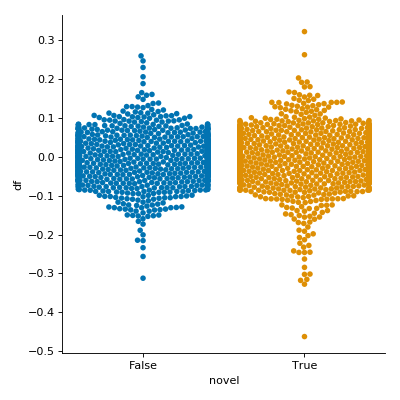

In [1619]:
sns.catplot(x='novel', y='df', data=grped, dodge=True, kind='swarm')

<IPython.core.display.Javascript object>


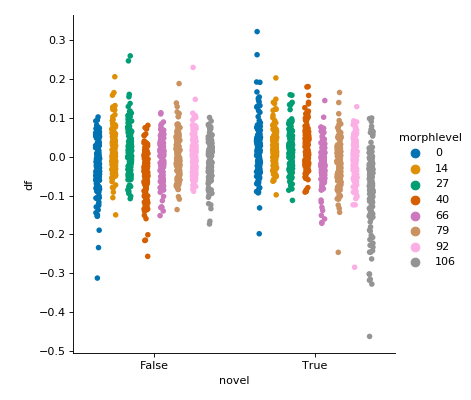

In [1616]:
sns.catplot(x='novel', y='df', hue='morphlevel', data=grped, dodge=True)

<IPython.core.display.Javascript object>


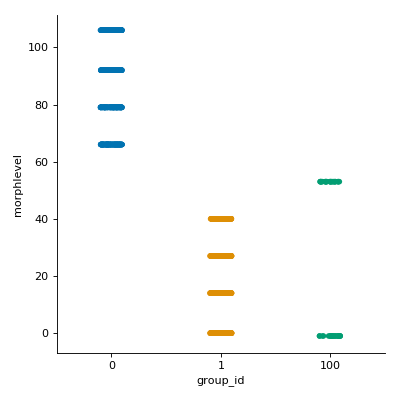

In [1449]:
sns.catplot(x='group_id', y='morphlevel', data=diff_from_prev)

# Visualize actual responses

In [1353]:

missing = []
data_f = []
for (animalid, session, fovnum), g in li_datasets.groupby(['animalid', 'session', 'fovnum']):
    data_str = '%s_%s_fov%i' % (session, animalid, fovnum)
    fov = 'FOV%i_zoom2p0x' % fovnum

    if data_str not in DATA.keys():
        missing.append(data_str)
        continue
        
    #trial_df = DATA[data_str]['data'].copy()
    tmpd = DATA[data_str]['data'].groupby(['config']).mean().stack().reset_index()
    tmpd = tmpd.rename(columns={0: response_metric, 'level_1': 'rid'})
    tmpd['data_id'] = [data_str for _ in np.arange(0, len(tmpd))]
    
    data_f.append(tmpd)
    

In [1354]:
df = pd.concat(data_f, axis=0)


In [1355]:
df.groupby(['data_id']).mean()

rid       dff
data_id                                  
20190422_JC076_fov1  183.278481  0.055336
20190502_JC076_fov1  116.716667  0.050041
20190602_JC091_fov1  177.217391  0.074046
20190605_JC090_fov1  133.177305  0.093699
20190606_JC091_fov1  150.054545  0.042444
20190607_JC091_fov1  319.691729  0.056429
20190609_JC099_fov1  190.774194  0.079070
20190612_JC099_fov1  135.062500  0.063015
20190614_JC091_fov1  267.491803  0.067890
20190617_JC099_fov1   47.444444  0.095009
20191008_JC091_fov1  275.328358  0.049210
20191018_JC113_fov1  120.220339  0.048206
20191105_JC117_fov1  102.483871  0.018875
20191111_JC120_fov1   71.760870  0.124163

## Some stats

<IPython.core.display.Javascript object>


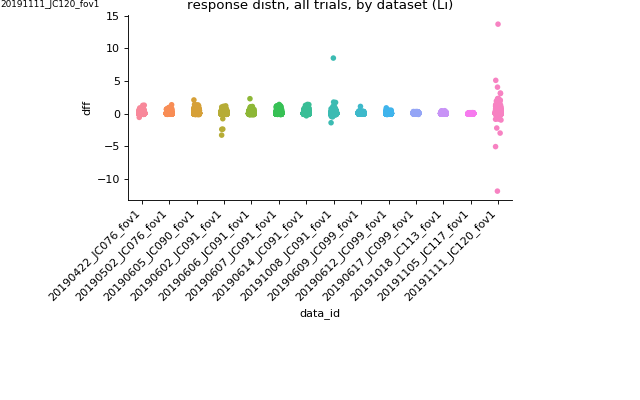

('/n/coxfs01/julianarhee/aggregate-visual-areas/stimulus_history', 'response_distn_dff_by_dataset_Li_all_trials.png')


In [1590]:
fg = sns.catplot(x='data_id', y='dff', data=df)
fg.set_xticklabels(rotation=45, horizontalalignment='right')
fg.fig.set_figwidth(8)
fg.fig.set_figheight(5)
# pl.subplots_adjust(bottom=0.5, left=0.1, right=0.8)

putils.label_figure(fg.fig, data_id)

pl.xticks(rotation=45, horizontalalignment='right')
pl.title('response distn, all trials, by dataset (Li)')
pl.subplots_adjust(bottom=0.5, left=0.2, right=0.8)

putils.label_figure(fig, data_id)
figname = 'response_distn_%s_by_dataset_Li_all_trials.png' % response_metric
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print(outdir, figname)

In [1035]:
ax.get_xticks()

array([0, 1])

## Look at @ single fov closely

<IPython.core.display.Javascript object>


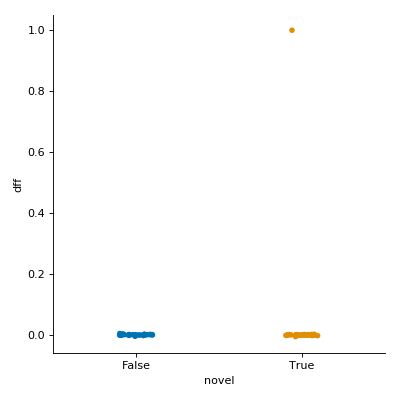

In [1006]:
curr_fov = '20191105_JC117_fov1' # '20190617_JC099_fov1'
currdf = mean_novel_all[mean_novel_all['data_id']==curr_fov].copy()
sns.catplot(x='novel', y=response_metric, data=currdf)


In [1014]:
mean_novel_all['level_0'].unique()

array([5, 32, 34, 41, 47, 60, 64, 69, 73, 76, 77, 80, 81, 87, 89, 93, 99,
       104, 112, 115, 116, 118, 119, 135, 136, 139, 140, 142, 144, 146,
       153, 156, 164, 165, 166, 168, 171, 172, 174, 175, 178, 183, 184,
       185, 186, 192, 194, 205, 209, 217, 221, 227, 228, 230, 240, 251,
       254, 261, 266, 268, 269, 272, 277, 281, 283, 284, 287, 292, 293,
       294, 296, 298, 303, 309, 316, 325, 327, 328, 329, 'novel', 0, 3, 4,
       6, 11, 14, 24, 26, 29, 40, 46, 48, 51, 66, 70, 75, 82, 84, 85, 94,
       96, 101, 107, 110, 117, 120, 121, 125, 126, 130, 152, 155, 161, 169,
       173, 181, 187, 190, 191, 193, 196, 197, 206, 207, 213, 219, 223,
       225, 1, 7, 13, 22, 25, 27, 30, 31, 33, 35, 36, 37, 39, 49, 50, 54,
       55, 56, 58, 59, 63, 65, 72, 74, 83, 86, 88, 90, 91, 92, 95, 98, 105,
       106, 109, 111, 113, 122, 123, 127, 128, 129, 132, 133, 134, 137,
       138, 145, 147, 148, 157, 159, 163, 170, 177, 179, 182, 188, 198,
       202, 203, 210, 226, 231, 232, 233, 235, 

<IPython.core.display.Javascript object>


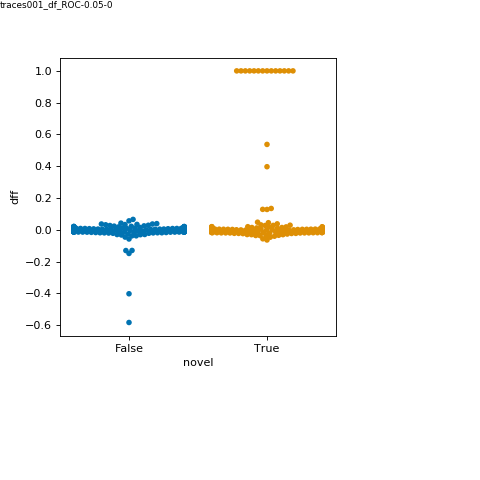

In [906]:
fig, ax = pl.subplots(figsize=(6,6)) #, dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
aix=0
offset = .25 #.25
plot_each = True
label_each=False
color = None if label_each else 'k'

#for si, sz in enumerate(sizes):
    
plotdf = mean_novel_all[mean_novel_all['data_id'].isin(d_strs)].copy() #[means_by_dset['size']==sz]
a_vals = plotdf[plotdf['novel']==False][response_metric].values
b_vals = plotdf[plotdf['novel']==True][response_metric].values

# sns.barplot("novel", response_metric, data=mean_novel_all, 
#              zorder=0,
#             ax=ax)
sns.swarmplot(x='novel', y=response_metric, data=mean_novel_all, ax=ax)
x1, x2 = [0, 1] #ax.get_xticks()

# if plot_each:
#     sns.set_palette('colorblind')
#     by_dset = [(a, b) for a, b in zip(a_vals, b_vals)]

#     for pi, p in enumerate(by_dset):
#         # if d in ['20190617_JC099_fov1', '20191111_JC120_fov1']:
#         #if d in ['20191111_JC120_fov1']:
#         #    continue
#         #label = d if si==4 and label_each else None
#         label=None
#         ax.plot([x1, x2], p, 
#                 marker=None, label=label, color=color, #area_colors[visual_area], 
#                 alpha=.5, lw=1,  zorder=0)


#             errcolor="k", edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
#ax.legend_.remove()
#ax.set_ylim(0.7, 1.2)
pl.subplots_adjust(right=0.7, bottom=0.3)
ax.legend(bbox_to_anchor=(1, 1), fontsize=8, title='Prev. Novel')

putils.label_figure(fig, data_id)

In [870]:
mean_novel_all

level_0  novel       dff              data_id  size
0        5  False  0.013676  20190422_JC076_fov1  50.0
1        5   True -0.013774  20190422_JC076_fov1  50.0
2       32  False -0.006676  20190422_JC076_fov1  50.0
3       32   True  0.006693  20190422_JC076_fov1  50.0
4       34  False  0.001670  20190422_JC076_fov1  50.0
5       34   True -0.001375  20190422_JC076_fov1  50.0
6       41  False  0.000460  20190422_JC076_fov1  50.0
7       41   True -0.000414  20190422_JC076_fov1  50.0
8       47  False  0.000938  20190422_JC076_fov1  50.0
9       47   True -0.000802  20190422_JC076_fov1  50.0
10      60  False  0.001919  20190422_JC076_fov1  50.0
11      60   True -0.002055  20190422_JC076_fov1  50.0
12      64  False  0.004277  20190422_JC076_fov1  50.0
13      64   True -0.004326  20190422_JC076_fov1  50.0
14      69  False  0.001117  20190422_JC076_fov1  50.0
15      69   True -0.001186  20190422_JC076_fov1  50.0
16      73  False -0.000443  20190422_JC076_fov1  50.0
17      73   True  0.000200  20190422_JC076_fov1  50.0
18      76  False  0.011322  20190422_JC076_fov1  50.0
19      76   True -0.012508  20190422_JC076_fov1  50.0
20      77  False  0.015206  20190422_JC076_fov1  50.0
21      77   True -0.014603  20190422_JC076_fov1  50.0
22      80  False  0.001102  20190422_JC076_fov1  50.0
23      80   True -0.001315  20190422_JC076_fov1  50.0
24      81  False -0.003223  20190422_JC076_fov1  50.0
25      81   True  0.002830  20190422_JC076_fov1  50.0
26      87  False  0.002585  20190422_JC076_fov1  50.0
27      87   True -0.002922  20190422_JC076_fov1  50.0
28      89  False -0.000063  20190422_JC076_fov1  50.0
29      89   True  0.000680  20190422_JC076_fov1  50.0
..     ...    ...       ...                  ...   ...
64      98  False  0.017135  20191111_JC120_fov1  50.0
65      98   True -0.016472  20191111_JC120_fov1  50.0
66     106  False  0.021479  20191111_JC120_fov1  50.0
67     106   True -0.023778  20191111_JC120_fov1  50.0
68     108  False -0.018319  20191111_JC120_fov1  50.0
69     108   True  0.017304  20191111_JC120_fov1  50.0
70     111  False -0.013620  20191111_JC120_fov1  50.0
71     111   True  0.009831  20191111_JC120_fov1  50.0
72     113  False -0.021635  20191111_JC120_fov1  50.0
73     113   True  0.019173  20191111_JC120_fov1  50.0
74     118  False -0.009332  20191111_JC120_fov1  50.0
75     118   True  0.008022  20191111_JC120_fov1  50.0
76     119  False -0.009701  20191111_JC120_fov1  50.0
77     119   True  0.008377  20191111_JC120_fov1  50.0
78     125  False  0.010498  20191111_JC120_fov1  50.0
79     125   True -0.009891  20191111_JC120_fov1  50.0
80     152  False  0.007967  20191111_JC120_fov1  50.0
81     152   True -0.007836  20191111_JC120_fov1  50.0
82     153  False  0.010417  20191111_JC120_fov1  50.0
83     153   True -0.009692  20191111_JC120_fov1  50.0
84     168  False  0.010590  20191111_JC120_fov1  50.0
85     168   True -0.009071  20191111_JC120_fov1  50.0
86     175  False  0.006806  20191111_JC120_fov1  50.0
87     175   True -0.006291  20191111_JC120_fov1  50.0
88     182  False -0.001122  20191111_JC120_fov1  50.0
89     182   True -0.000193  20191111_JC120_fov1  50.0
90     189  False -0.010102  20191111_JC120_fov1  50.0
91     189   True  0.009663  20191111_JC120_fov1  50.0
92   novel  False  0.000000  20191111_JC120_fov1  50.0
93   novel   True  1.000000  20191111_JC120_fov1  50.0

[2450 rows x 5 columns]

# Look at each dset

<IPython.core.display.Javascript object>


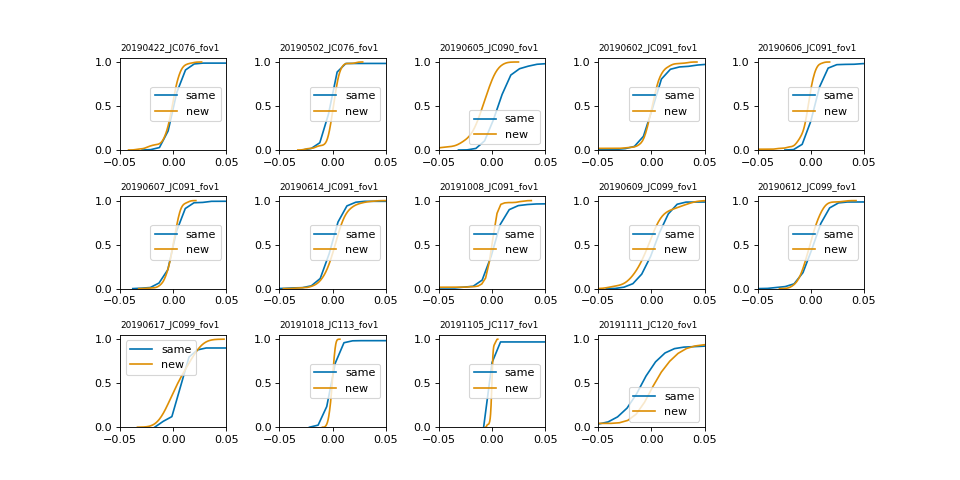

In [990]:
data_ids = mean_novel_all['data_id'].unique()
fig, axes = pl.subplots(3, 5, figsize=(12, 6))
for ai, ax in enumerate(axes.flat):
    if ai >= len(data_ids):
        ax.axis('off')
        continue
    curr_vals = mean_novel_all[mean_novel_all['data_id']==data_ids[ai]]
#     sns.distplot(curr_vals[curr_vals['novel']==True][response_metric], label='same', ax=ax)
#     sns.distplot(curr_vals[curr_vals['novel']==False][response_metric], label='new', ax=ax)
    sns.kdeplot(curr_vals[curr_vals['novel']==True][response_metric], label='same', ax=ax, cumulative=True)
    sns.kdeplot(curr_vals[curr_vals['novel']==False][response_metric], label='new', ax=ax, cumulative=True)
    
    ax.set_title(data_ids[ai], loc='left', fontsize=8)
    
    ax.set_xlim([-0.05, 0.05])
pl.subplots_adjust(hspace=0.5, wspace=0.5)

<IPython.core.display.Javascript object>


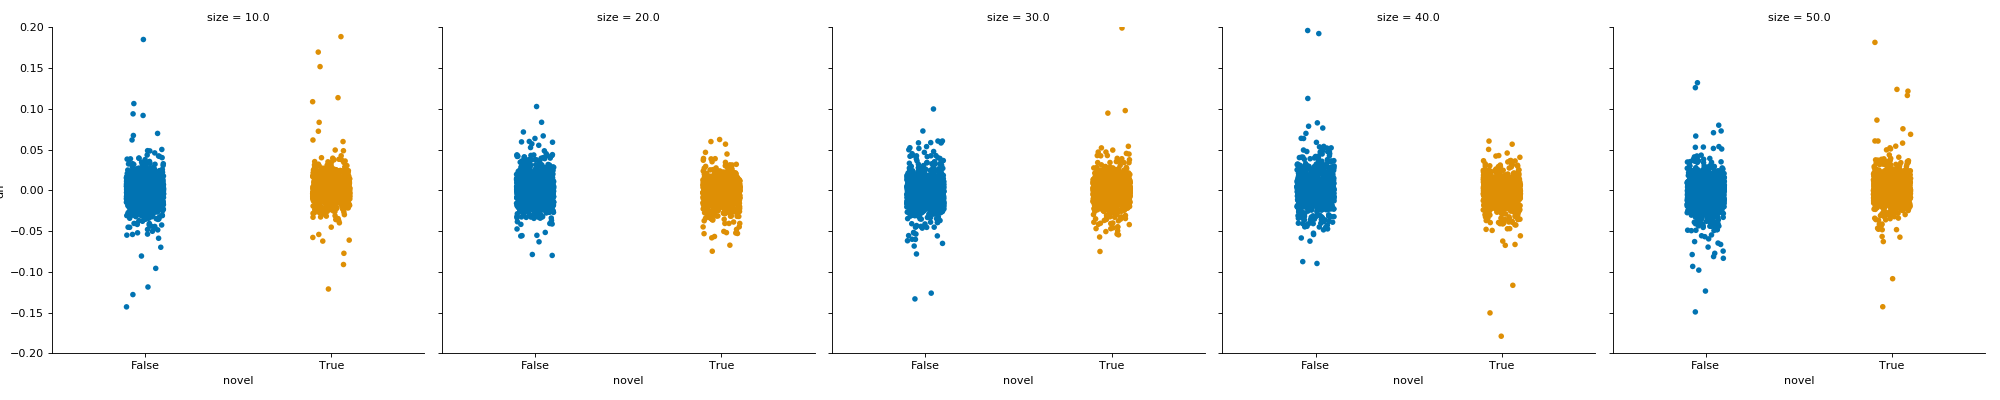

(-0.2, 0.2)

In [800]:
sns.catplot(x='novel', y=response_metric, hue='novel', col='size', data=mean_novel_all,
           jitter=True)
pl.ylim([-0.2, 0.2])

<IPython.core.display.Javascript object>


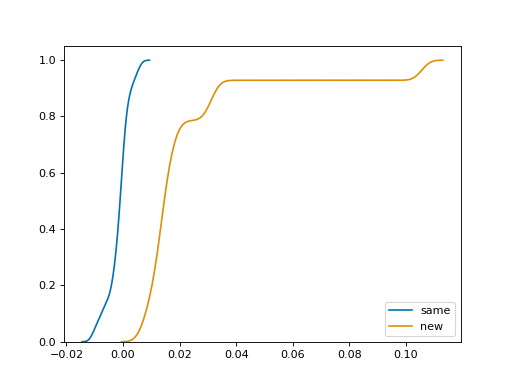

In [991]:
# plot
fig, ax = pl.subplots()
kwargs = {'cumulative': True}
average_by_fov = True

if average_by_fov:
    currdf = means_by_dset[['novel', response_metric]].copy()
else:
    currdf = mean_novel_all[['novel', response_metric]].copy()


sns.kdeplot(currdf[currdf['novel']==0][response_metric], label='same', ax=ax, 
            cumulative=True)
sns.kdeplot(currdf[currdf['novel']==1][response_metric], label='new', ax=ax,
            cumulative=True)

pl.legend()

In [ ]:
'20190617_JC099_fov1'

/n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_66b289_traces001_e95cc2_traces001_b96bf7_traces001_9cb69c_traces001_3485a6_traces001_7be2ae/data_arrays/np_subtracted.npz
JC076_20190422_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0
[loading dataset]: /n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_66b289_traces001_e95cc2_traces001_b96bf7_traces001_9cb69c_traces001_3485a6_traces001_7be2ae/data_arrays/np_subtracted.npz
NP_subtracted offset was: 179.98
adding NP offset... (NP f0 offset: 877.52)
((249000, 331), (331,), ())
adding raw offset... (raw f0 offset: 822.11)
(1500, 331)
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_66b289_traces001_e95cc2_traces001_b96bf7_traces001_9cb69c_traces001_3485a6_traces001_7be2ae/summary_stats/ROC/roc_results.pkl']
...loading stats
loaded
79 out of 331 cells passed responsive test metric
((4, 8), (4, 8))
(2

<IPython.core.display.Javascript object>


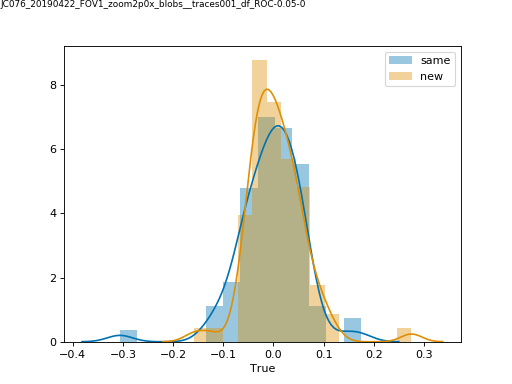

('/n/coxfs01/julianarhee/aggregate-visual-areas/stimulus_history', 'same-v-new_distn_1-back_zscore-responses_sz-30__id_JC076_20190422_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0')
/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_bc0893_traces001_05b262_traces001_cdf7b0_traces001_2649ff_traces001_e62928_traces001_82b664/data_arrays/np_subtracted.npz
JC076_20190502_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0
[loading dataset]: /n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_bc0893_traces001_05b262_traces001_cdf7b0_traces001_2649ff_traces001_e62928_traces001_82b664/data_arrays/np_subtracted.npz
NP_subtracted offset was: 187.56
adding NP offset... (NP f0 offset: 797.64)
((185490, 226), (226,), ())
adding raw offset... (raw f0 offset: 769.87)
(1374, 226)
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_bc0893_traces001_05b262_traces001_cdf7b0

<IPython.core.display.Javascript object>


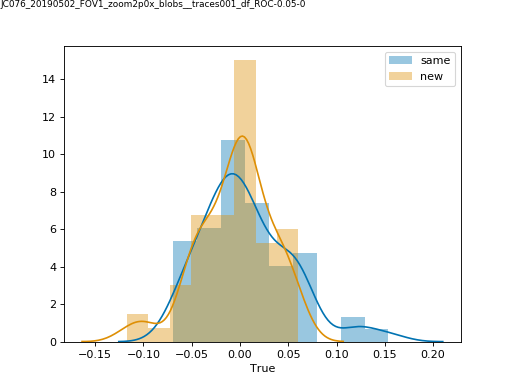

('/n/coxfs01/julianarhee/aggregate-visual-areas/stimulus_history', 'same-v-new_distn_1-back_zscore-responses_sz-30__id_JC076_20190502_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0')
/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5afb30_traces001_ea6bc7_traces001_9747d8_traces001_70031f_traces001_ba4282_traces001_c2eec5_traces001_5c088e/data_arrays/np_subtracted.npz
JC090_20190605_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0
[loading dataset]: /n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5afb30_traces001_ea6bc7_traces001_9747d8_traces001_70031f_traces001_ba4282_traces001_c2eec5_traces001_5c088e/data_arrays/np_subtracted.npz
NP_subtracted offset was: 12.62
adding NP offset... (NP f0 offset: 524.30)
((220725, 271), (271,), ())
adding raw offset... (raw f0 offset: 403.97)
(1635, 271)
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5afb30_

<IPython.core.display.Javascript object>


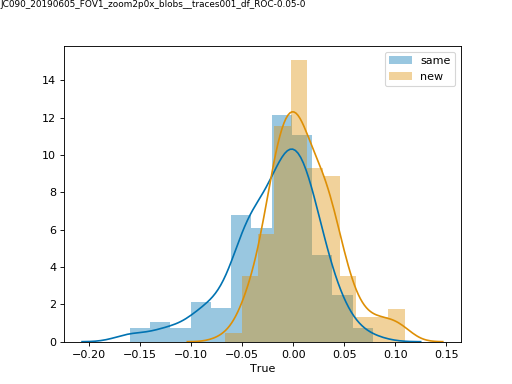

('/n/coxfs01/julianarhee/aggregate-visual-areas/stimulus_history', 'same-v-new_distn_1-back_zscore-responses_sz-30__id_JC090_20190605_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0')
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_573669_traces001_3d2687_traces001_17838a_traces001_452178_traces001_c84a17_traces001_faae98/data_arrays/np_subtracted.npz
JC091_20190602_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0
[loading dataset]: /n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_573669_traces001_3d2687_traces001_17838a_traces001_452178_traces001_c84a17_traces001_faae98/data_arrays/np_subtracted.npz
NP_subtracted offset was: 62.92
adding NP offset... (NP f0 offset: 372.48)
((202365, 356), (356,), ())
adding raw offset... (raw f0 offset: 339.97)
(1499, 356)
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_573669_traces001_3d2687_traces001_17838a_

<IPython.core.display.Javascript object>


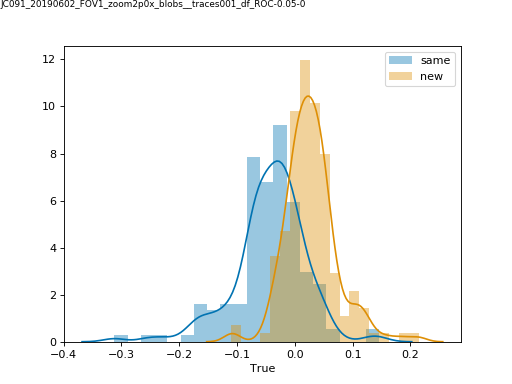

('/n/coxfs01/julianarhee/aggregate-visual-areas/stimulus_history', 'same-v-new_distn_1-back_zscore-responses_sz-30__id_JC091_20190602_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0')
/n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_c8905e_traces001_cca83f_traces001_282089_traces001_d63f40_traces001_5e8ae8_traces001_d9484e_traces001_a6f53c/data_arrays/np_subtracted.npz
JC091_20190606_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0
[loading dataset]: /n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_c8905e_traces001_cca83f_traces001_282089_traces001_d63f40_traces001_5e8ae8_traces001_d9484e_traces001_a6f53c/data_arrays/np_subtracted.npz
NP_subtracted offset was: 58.58
adding NP offset... (NP f0 offset: 583.73)
((219375, 314), (314,), ())
adding raw offset... (raw f0 offset: 495.35)
(1625, 314)
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_c8905e_

<IPython.core.display.Javascript object>


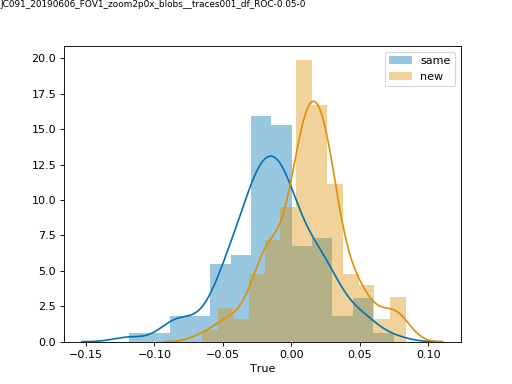

('/n/coxfs01/julianarhee/aggregate-visual-areas/stimulus_history', 'same-v-new_distn_1-back_zscore-responses_sz-30__id_JC091_20190606_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0')
/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_2afecb_traces001_8b62a3_traces001_fa925f_traces001_bcbaba_traces001_821fff_traces001_361c93/data_arrays/np_subtracted.npz
JC091_20190607_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0
[loading dataset]: /n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_2afecb_traces001_8b62a3_traces001_fa925f_traces001_bcbaba_traces001_821fff_traces001_361c93/data_arrays/np_subtracted.npz
NP_subtracted offset was: 51.31
adding NP offset... (NP f0 offset: 427.79)
((202500, 526), (526,), ())
adding raw offset... (raw f0 offset: 369.25)
(1500, 526)
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_2afecb_traces001_8b62a3_traces001_fa925f_

<IPython.core.display.Javascript object>


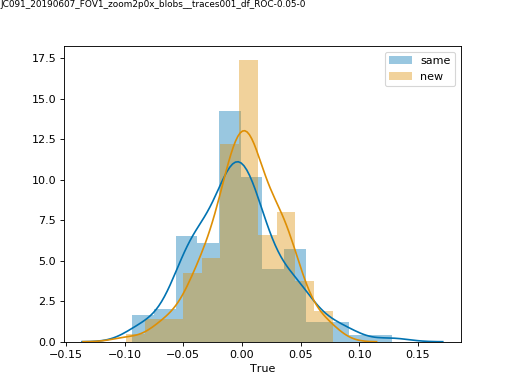

('/n/coxfs01/julianarhee/aggregate-visual-areas/stimulus_history', 'same-v-new_distn_1-back_zscore-responses_sz-30__id_JC091_20190607_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0')
/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1109ae_traces001_920e9d_traces001_8dceeb_traces001_7c7a76_traces001_cc90dc_traces001_344475/data_arrays/np_subtracted.npz
JC091_20190614_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0
[loading dataset]: /n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1109ae_traces001_920e9d_traces001_8dceeb_traces001_7c7a76_traces001_cc90dc_traces001_344475/data_arrays/np_subtracted.npz
NP_subtracted offset was: 15.63
adding NP offset... (NP f0 offset: 327.50)
((202500, 533), (533,), ())
adding raw offset... (raw f0 offset: 258.99)
(1500, 533)
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1109ae_traces001_920e9d_traces001_8dceeb_

<IPython.core.display.Javascript object>


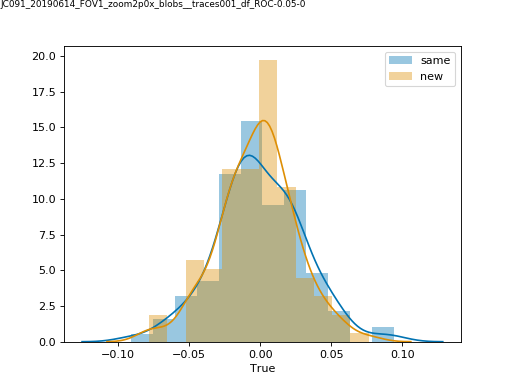

('/n/coxfs01/julianarhee/aggregate-visual-areas/stimulus_history', 'same-v-new_distn_1-back_zscore-responses_sz-30__id_JC091_20190614_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0')
/n/coxfs01/2p-data/JC091/20191008/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_cc68de_traces001_2c5f0a_traces001_98b90b_traces001_7702d2_traces001_ca65ed_traces001_035050_traces001_2cd0d5_traces001_445323_traces001_e162ea_traces001_6372e2_traces001_e30953_traces001_96e3d7_traces001_a6c8d0/data_arrays/np_subtracted.npz
JC091_20191008_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0
[loading dataset]: /n/coxfs01/2p-data/JC091/20191008/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_cc68de_traces001_2c5f0a_traces001_98b90b_traces001_7702d2_traces001_ca65ed_traces001_035050_traces001_2cd0d5_traces001_445323_traces001_e162ea_traces001_6372e2_traces001_e30953_traces001_96e3d7_traces001_a6c8d0/data_arrays/np_subtracted.npz
NP_subtracted offset was: -18.51
adding NP offset... (NP f0 offset: 758.05)
((425250

<IPython.core.display.Javascript object>


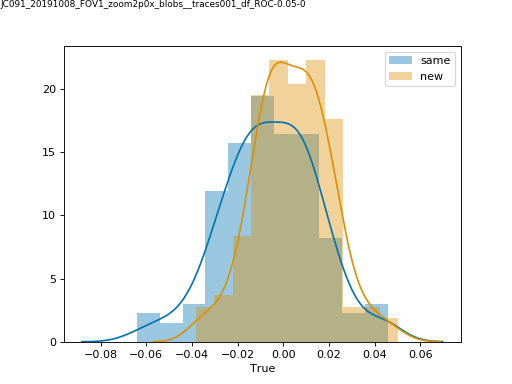

('/n/coxfs01/julianarhee/aggregate-visual-areas/stimulus_history', 'same-v-new_distn_1-back_zscore-responses_sz-30__id_JC091_20191008_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0')
/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_2be711_traces001_333f6c_traces001_31bd42_traces001_0b8503_traces001_2d8e76_traces001_8fe19c/data_arrays/np_subtracted.npz
JC099_20190609_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0
[loading dataset]: /n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_2be711_traces001_333f6c_traces001_31bd42_traces001_0b8503_traces001_2d8e76_traces001_8fe19c/data_arrays/np_subtracted.npz
NP_subtracted offset was: -8.23
adding NP offset... (NP f0 offset: 440.92)
((202500, 311), (311,), ())
adding raw offset... (raw f0 offset: 323.66)
(1500, 311)
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_2be711_traces001_333f6c_traces001_31bd42_

<IPython.core.display.Javascript object>


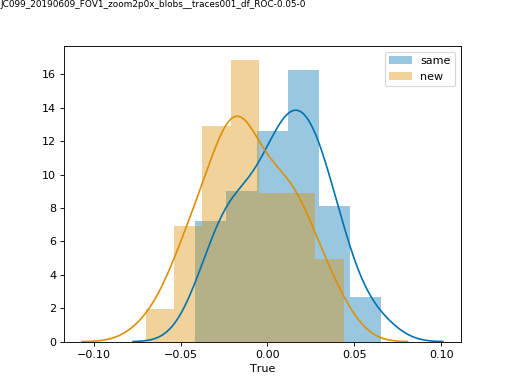

('/n/coxfs01/julianarhee/aggregate-visual-areas/stimulus_history', 'same-v-new_distn_1-back_zscore-responses_sz-30__id_JC099_20190609_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0')
/n/coxfs01/2p-data/JC099/20190612/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d86de1_traces001_8df9ce_traces001_61ca30_traces001_0266b8_traces001_111679_traces001_0abebe/data_arrays/np_subtracted.npz
JC099_20190612_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0
[loading dataset]: /n/coxfs01/2p-data/JC099/20190612/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d86de1_traces001_8df9ce_traces001_61ca30_traces001_0266b8_traces001_111679_traces001_0abebe/data_arrays/np_subtracted.npz
NP_subtracted offset was: 40.01
adding NP offset... (NP f0 offset: 785.50)
((202500, 269), (269,), ())
adding raw offset... (raw f0 offset: 623.33)
(1500, 269)
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC099/20190612/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d86de1_traces001_8df9ce_traces001_61ca30_

<IPython.core.display.Javascript object>


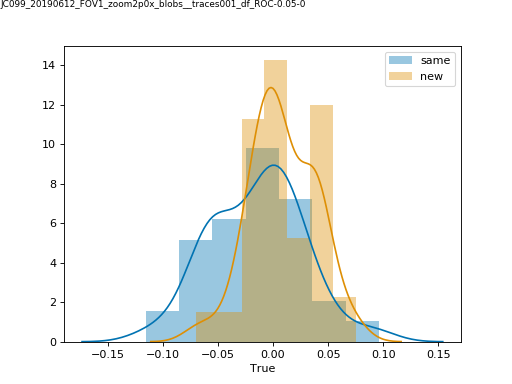

('/n/coxfs01/julianarhee/aggregate-visual-areas/stimulus_history', 'same-v-new_distn_1-back_zscore-responses_sz-30__id_JC099_20190612_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0')
/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_94cb73_traces001_9d8a71_traces001_7a514c_traces001_864da3/data_arrays/np_subtracted.npz
JC099_20190617_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0
[loading dataset]: /n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_94cb73_traces001_9d8a71_traces001_7a514c_traces001_864da3/data_arrays/np_subtracted.npz
NP_subtracted offset was: 3.88
adding NP offset... (NP f0 offset: 854.19)
((131355, 102), (102,), ())
adding raw offset... (raw f0 offset: 642.01)
(973, 102)
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_94cb73_traces001_9d8a71_traces001_7a514c_traces001_864da3/summary_stats/ROC/roc_results.pkl']
...loading stats


<IPython.core.display.Javascript object>


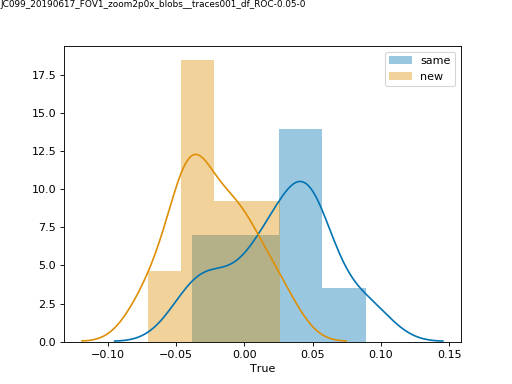

('/n/coxfs01/julianarhee/aggregate-visual-areas/stimulus_history', 'same-v-new_distn_1-back_zscore-responses_sz-30__id_JC099_20190617_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0')
/n/coxfs01/2p-data/JC113/20191018/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_45d7bf_traces001_9d98af_traces001_e6dd0f_traces001_af8efe_traces001_53b0c3_traces001_48b222_traces001_5a33cb_traces001_636e28_traces001_9675ee_traces001_c992b1_traces001_deae7e/data_arrays/np_subtracted.npz
JC113_20191018_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0
[loading dataset]: /n/coxfs01/2p-data/JC113/20191018/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_45d7bf_traces001_9d98af_traces001_e6dd0f_traces001_af8efe_traces001_53b0c3_traces001_48b222_traces001_5a33cb_traces001_636e28_traces001_9675ee_traces001_c992b1_traces001_deae7e/data_arrays/np_subtracted.npz
NP_subtracted offset was: 78.22
adding NP offset... (NP f0 offset: 1102.53)
((317250, 210), (210,), ())
adding raw offset... (raw f0 offset: 896.86)
(23

<IPython.core.display.Javascript object>


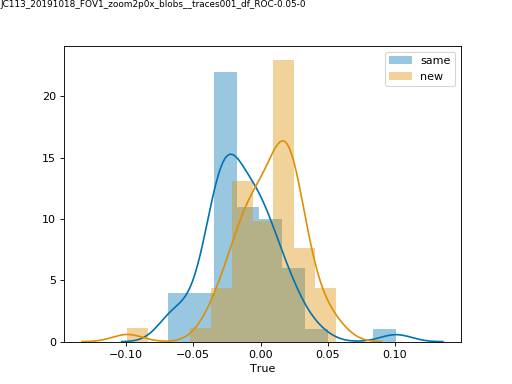

('/n/coxfs01/julianarhee/aggregate-visual-areas/stimulus_history', 'same-v-new_distn_1-back_zscore-responses_sz-30__id_JC113_20191018_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0')
/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1621ed_traces001_99712e_traces001_498354_traces001_92ea72_traces001_e3ab25_traces001_a2c0dd/data_arrays/np_subtracted.npz
JC117_20191105_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0
[loading dataset]: /n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1621ed_traces001_99712e_traces001_498354_traces001_92ea72_traces001_e3ab25_traces001_a2c0dd/data_arrays/np_subtracted.npz
NP_subtracted offset was: 49224146538.97
adding NP offset... (NP f0 offset: 49393354160.23)
((182250, 235), (235,), ())
adding raw offset... (raw f0 offset: 49393353907.87)
(1350, 235)
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1621ed_traces001

<IPython.core.display.Javascript object>


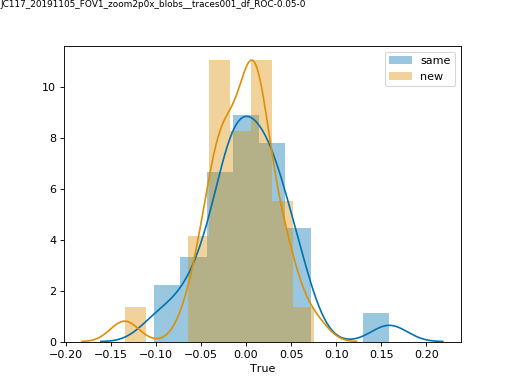

('/n/coxfs01/julianarhee/aggregate-visual-areas/stimulus_history', 'same-v-new_distn_1-back_zscore-responses_sz-30__id_JC117_20191105_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0')
/n/coxfs01/2p-data/JC120/20191111/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_603e33_traces001_b209e8_traces001_0b0a19_traces001_67c45c_traces001_8513ce_traces001_12f240/data_arrays/np_subtracted.npz
JC120_20191111_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0
[loading dataset]: /n/coxfs01/2p-data/JC120/20191111/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_603e33_traces001_b209e8_traces001_0b0a19_traces001_67c45c_traces001_8513ce_traces001_12f240/data_arrays/np_subtracted.npz
NP_subtracted offset was: -32.03
adding NP offset... (NP f0 offset: 169.75)
((202500, 190), (190,), ())
adding raw offset... (raw f0 offset: 103.81)
(1500, 190)
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC120/20191111/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_603e33_traces001_b209e8_traces001_0b0a19

<IPython.core.display.Javascript object>


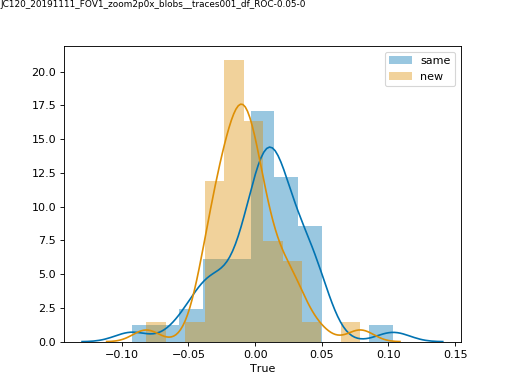

('/n/coxfs01/julianarhee/aggregate-visual-areas/stimulus_history', 'same-v-new_distn_1-back_zscore-responses_sz-30__id_JC120_20191111_FOV1_zoom2p0x_blobs__traces001_df_ROC-0.05-0')


In [270]:
# Select metric
response_metric = 'zscore'
all_transforms = True
curr_size = 30.

# animalid = 'JC090' #'JC113' #'JC117'
# session = '20190605' # '20191018' #'20191105'

# # animalid = 'JC084'
# # session = '20190522'
# fov = 'FOV1_zoom2p0x'

stimulus = 'blobs'

dfs = []
for (animalid, session, fovnum), g in li_blobs.groupby(['animalid', 'session', 'fovnum']):
    fov = 'FOV%i_zoom2p0x' % fovnum
        
    soma_fpath = glob.glob(os.path.join(rootdir, animalid, session, fov, '*%s*' % stimulus, 'traces', '%s*' % traceid,
                                        'data_arrays', 'np_subtracted.npz'))[0]
    print(soma_fpath)

    fig_id = '%s_%s_%s_%s__%s' % (animalid, session, fov, stimulus, data_id)
    print(fig_id)

    # Load traces
    traces, labels, sdf, run_info = putils.load_dataset(soma_fpath, trace_type=trace_type)

    # Get response metric for each trial
    trial_metrics = util.get_trial_metrics(traces, labels, response_type=response_metric, nframes_post_onset=None)
    print(trial_metrics.shape)

    # Get cells that are visually responsive, if manual ROIs
    run_name = 'combined_%s_static' % stimulus
    responsive_cells, n_cells_total = util.get_responsive_cells(animalid, session, fov, run=run_name, traceid=traceid,
                                                           responsive_test=responsive_test, 
                                                           responsive_thr=responsive_thr, 
                                                           n_stds=n_stds)
    print("%i out of %i cells passed responsive test metric" % (len(responsive_cells), n_cells_total))

    # Select subset of data (responsive cells only)
    trial_df = trial_metrics[responsive_cells].copy()
    trial_df['config'] = [c[0] for c in labels.groupby(['trial'])['config'].unique().reset_index()['config']]

    # Select stimulus conditions
    if stimulus == 'gratings':
        # Similarity by orientation
        curr_sf = 0.1
        curr_speed = 10
        curr_size = sdf['size'].min()
        curr_sdf = sdf[(sdf['sf']==curr_sf) & (sdf['speed']==curr_speed) & (sdf['size']==curr_size)].copy()
    else:
        if all_transforms:
            curr_sdf = sdf[(sdf['morphlevel']!=-1) & (sdf['morphlevel']!=53)].copy()
        else:
            curr_sdf = sdf[(sdf['morphlevel']!=-1) & (sdf['morphlevel']!=53)
                          & (sdf['size']==curr_size)].copy()

    # Group by "similarity"
    if stimulus == 'gratings':
        group_a = curr_sdf[curr_sdf['ori']<180.]
        group_b = curr_sdf[curr_sdf['ori']>=180.]
    else:
        group_a = curr_sdf[curr_sdf['morphlevel']<53]
        group_b = curr_sdf[curr_sdf['morphlevel']>53]
        
    print(group_a.shape, group_b.shape)
    curr_conditions = np.union1d(group_a.index.tolist(), group_b.index.tolist())

    # Select subset of trials where cond shown
    curr_trials = trial_df[trial_df['config'].isin(curr_conditions)].copy()
    print(curr_trials.shape)

    # Assign same/different label for each trial
    curr_trials['group_id'] = [1 if curr_cfg in group_a.index.tolist() else 0 for curr_cfg in curr_trials['config']]

    # Group responses by A or B
    responses_by_group = curr_trials.copy()
    responses_by_group = responses_by_group.drop('config', 1)

    # Get change in response relative to previous trial
    delta_responses = responses_by_group - responses_by_group.shift() # subtract each row from subsequent row
    delta_responses = delta_responses.drop(delta_responses.index[0])  # drop first row (nan)
    delta_responses['novel'] = [f!=0 for f in delta_responses['group_id']] # flag whether same or diff

    # Get average response by novel or same group
    mean_novel = delta_responses.drop('group_id', 1).groupby(['novel']).mean().T
    
    # add to df
    data_str = '%s_%s_fov%i' % (session, animalid, fovnum)
    mean_novel['data_id'] = [data_str for _ in np.arange(0, len(mean_novel))]
    
    dfs.append(mean_novel)
    
    # plot
    fig, ax = pl.subplots()
    sns.distplot(mean_novel[0], label='same', ax=ax)
    sns.distplot(mean_novel[1], label='new', ax=ax)
    pl.legend()
    putils.label_figure(fig, fig_id)
    if all_transforms:
        figname = 'same-v-new_distn_1-back_%s-responses_all-sizes__id_%s' % (response_metric, fig_id)
    else:
        figname = 'same-v-new_distn_1-back_%s-responses_sz-%i__id_%s' % (response_metric, curr_size, fig_id)

    pl.savefig(os.path.join(outdir, '%s.png' % figname))
    print(outdir, figname)


In [272]:
mean_novel_all = pd.concat(dfs, axis=0)
mean_novel_all.head()

novel     False      True              data_id
5     -0.050089  0.039530  20190422_JC076_fov1
32     0.017598 -0.021698  20190422_JC076_fov1
34    -0.018874  0.017470  20190422_JC076_fov1
41     0.061348 -0.052952  20190422_JC076_fov1
47     0.050297 -0.044164  20190422_JC076_fov1

<IPython.core.display.Javascript object>


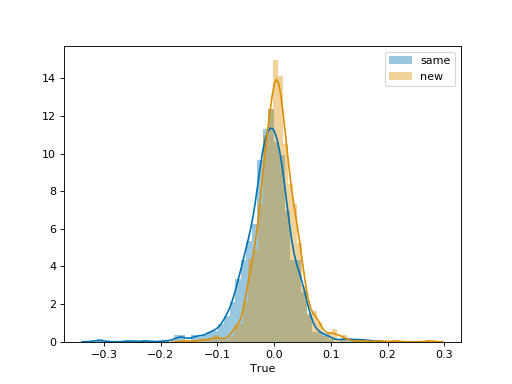

In [273]:

# plot
fig, ax = pl.subplots()
sns.distplot(mean_novel_all[0], label='same', ax=ax)
sns.distplot(mean_novel_all[1], label='new', ax=ax)
pl.legend()

In [275]:

len(mean_novel_all['data_id'].unique())

14

<IPython.core.display.Javascript object>


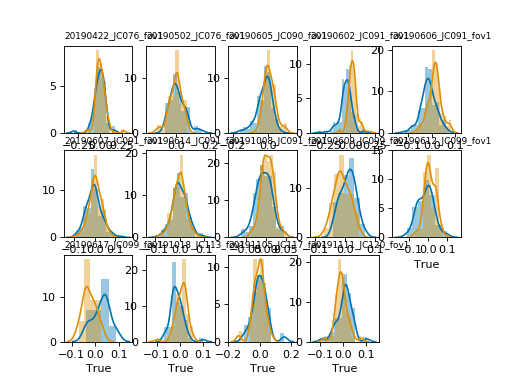

In [281]:
data_ids = mean_novel_all['data_id'].unique()
fig, axes = pl.subplots(3, 5)
for ai, ax in enumerate(axes.flat):
    if ai >= len(data_ids):
        ax.axis('off')
        continue
    curr_vals = mean_novel_all[mean_novel_all['data_id']==data_ids[ai]]
    sns.distplot(curr_vals[0], label='same', ax=ax)
    sns.distplot(curr_vals[1], label='new', ax=ax)
    ax.set_title(data_ids[ai], loc='left', fontsize=8)

In [279]:
data_ids)


array(['20190422_JC076_fov1', '20190502_JC076_fov1', '20190605_JC090_fov1',
       '20190602_JC091_fov1', '20190606_JC091_fov1', '20190607_JC091_fov1',
       '20190614_JC091_fov1', '20191008_JC091_fov1', '20190609_JC099_fov1',
       '20190612_JC099_fov1', '20190617_JC099_fov1', '20191018_JC113_fov1',
       '20191105_JC117_fov1', '20191111_JC120_fov1'], dtype=object)

In [152]:
def process_traces(raw_traces, labels, response_type='dff', nframes_post_onset=None):

    stim_on_frame = labels['stim_on_frame'].unique()[0]
    tmp_df = []
    for k, g in labels.groupby(['trial']):
        tmat = raw_traces.loc[g.index]
        bas_mean = np.nanmean(tmat[0:stim_on_frame], axis=0)
        if response_type == 'dff':
            tmat_df = (tmat - bas_mean) / bas_mean
        elif response_type == 'zscore':
            bas_std = np.nanstd(tmat[0:stim_on_frame], axis=0)
            #tmat_df = (tmat - bas_mean) / bas_std
            tmat_df = tmat / bas_std
        tmp_df.append(tmat_df)
    processed_traces = pd.concat(tmp_df, axis=0)
    
    return processed_traces

In [153]:
zscored_traces = process_traces(traces, labels, response_type='zscore', nframes_post_onset=None)

In [154]:
zscored_traces.shape

(317250, 210)

## Plot traces sorted by time

#### Look at traces for 1 cell

In [155]:
curr_trials.groupby(['config']).mean().max()

1           0.119181
4           0.159041
7           0.147850
10          0.221715
44          0.148654
45          0.128079
55          0.215358
56          0.164193
59          0.104951
61          0.118761
63          0.103719
67          0.054566
68          0.145701
70          0.178262
75          0.168135
85          0.339098
88          0.290232
95          0.602496
96          0.219984
98          0.297229
101         0.651047
105         0.075644
108         0.338950
110         0.339577
111         0.127723
117         0.296596
120         0.142064
123         0.204216
124         0.188544
128         0.174536
130         0.282598
132         0.344420
134         0.122657
137         0.144229
138         0.103482
140         0.282257
146         0.131908
151         0.152679
154         0.180739
156         0.110742
158         0.085851
159         0.231016
160         0.098601
161         0.235258
163         0.308680
164         0.129702
165         0.105547
171         0

In [176]:
rid = 101 #22 #21
curr_traces = labels.copy()
#curr_traces[trace_type] = zscored_traces[rid].copy()
curr_traces[trace_type] = traces[rid].copy()

print(curr_traces.shape)
roi_df = curr_trials[[rid, 'config']]


(317250, 9)


In [177]:
trial_df.shape, curr_trials.shape

((2350, 60), (376, 61))

In [178]:
curr_traces['repnum'] = [-1 for _ in np.arange(0, curr_traces.shape[0])]
for cfg, g in curr_traces.groupby(['config']):
    trial_nums = dict((t, i) for i, t in enumerate(sorted(g['trial'].unique(), key=putils.natural_keys)))
    curr_traces['repnum'][g.index] = [trial_nums[t] for t in g['trial']]
    

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [179]:
curr_traces['size'] = [sdf['size'][cfg] for cfg in curr_traces['config']]
curr_traces['morphlevel'] = [sdf['morphlevel'][cfg] for cfg in curr_traces['config']]

<IPython.core.display.Javascript object>


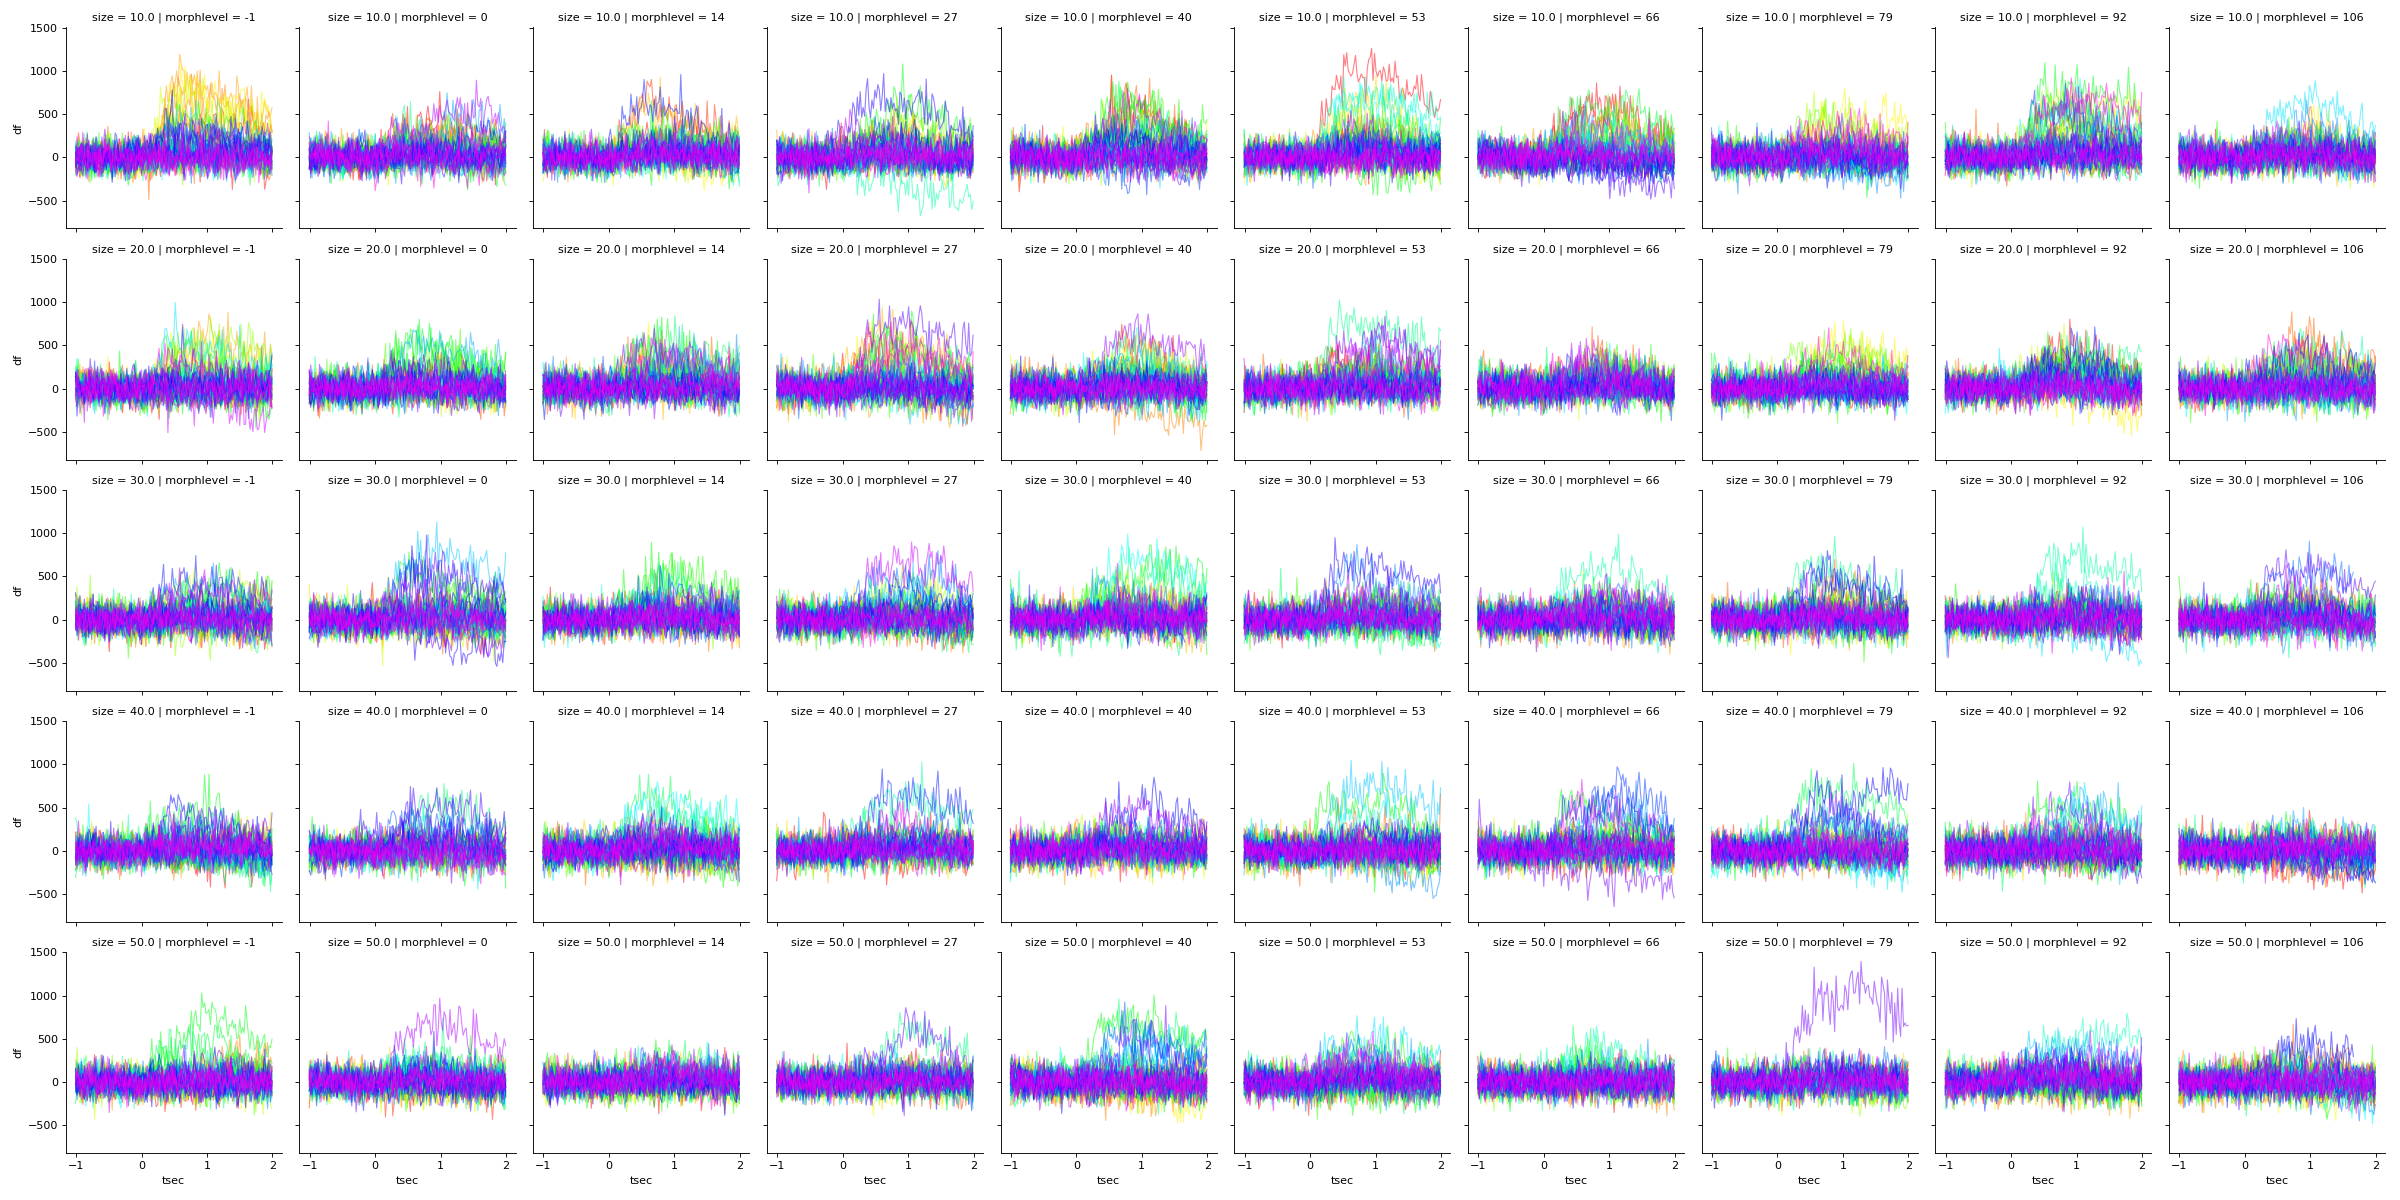

In [180]:

p = sns.FacetGrid(curr_traces, col='morphlevel', row='size', hue='repnum',\
                  sharex=True, sharey=True, palette='gist_rainbow')
p = p.map(pl.plot, "tsec", trace_type, lw=1, alpha=0.5) #, color='k')

In [270]:
#p = p.map(pl.fill_between, "tsec", "fill_minus", "fill_plus", alpha=0.5, color='k')
#p = p.map(pl.plot, "tsec", trace_type, lw=1, alpha=0.5) #, color='k')

In [161]:
sdf['size'].unique()

array([ 10.,  20.,  30.,  40.,  50.])

<IPython.core.display.Javascript object>


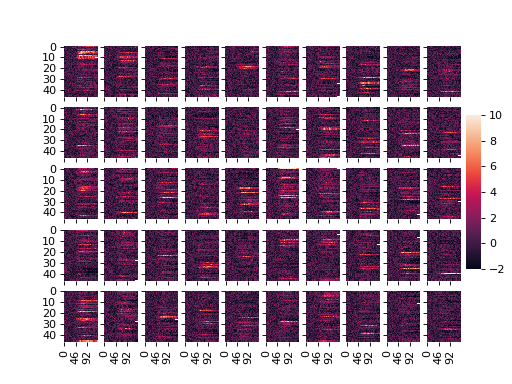

In [162]:
n_sizes = len(sdf['size'].unique())
n_morphs = len(sdf['morphlevel'].unique())

fig, axn = pl.subplots(n_sizes, n_morphs, sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
ai = 0
for (mp, sz), g in curr_traces.groupby(['morphlevel', 'size']):
    ax = axn.flat[ai]
    trial_mat = np.vstack(g.groupby(['trial'])[trace_type].apply(np.array).values)
    sns.heatmap(trial_mat, ax=ax, 
               cbar=ai==0,
               vmin=-2, vmax=10, 
               cbar_ax=None if ai else cbar_ax)
    ai += 1

#### Look at full traces

In [53]:
nframes_on = labels['nframes_on'].unique()[0]
stim_on_frame = labels['stim_on_frame'].unique()[0]

stim_on_ixs = [g.index.tolist()[stim_on_frame] for t, g in labels.groupby(['trial'])]
len(stim_on_ixs)


1349

<IPython.core.display.Javascript object>


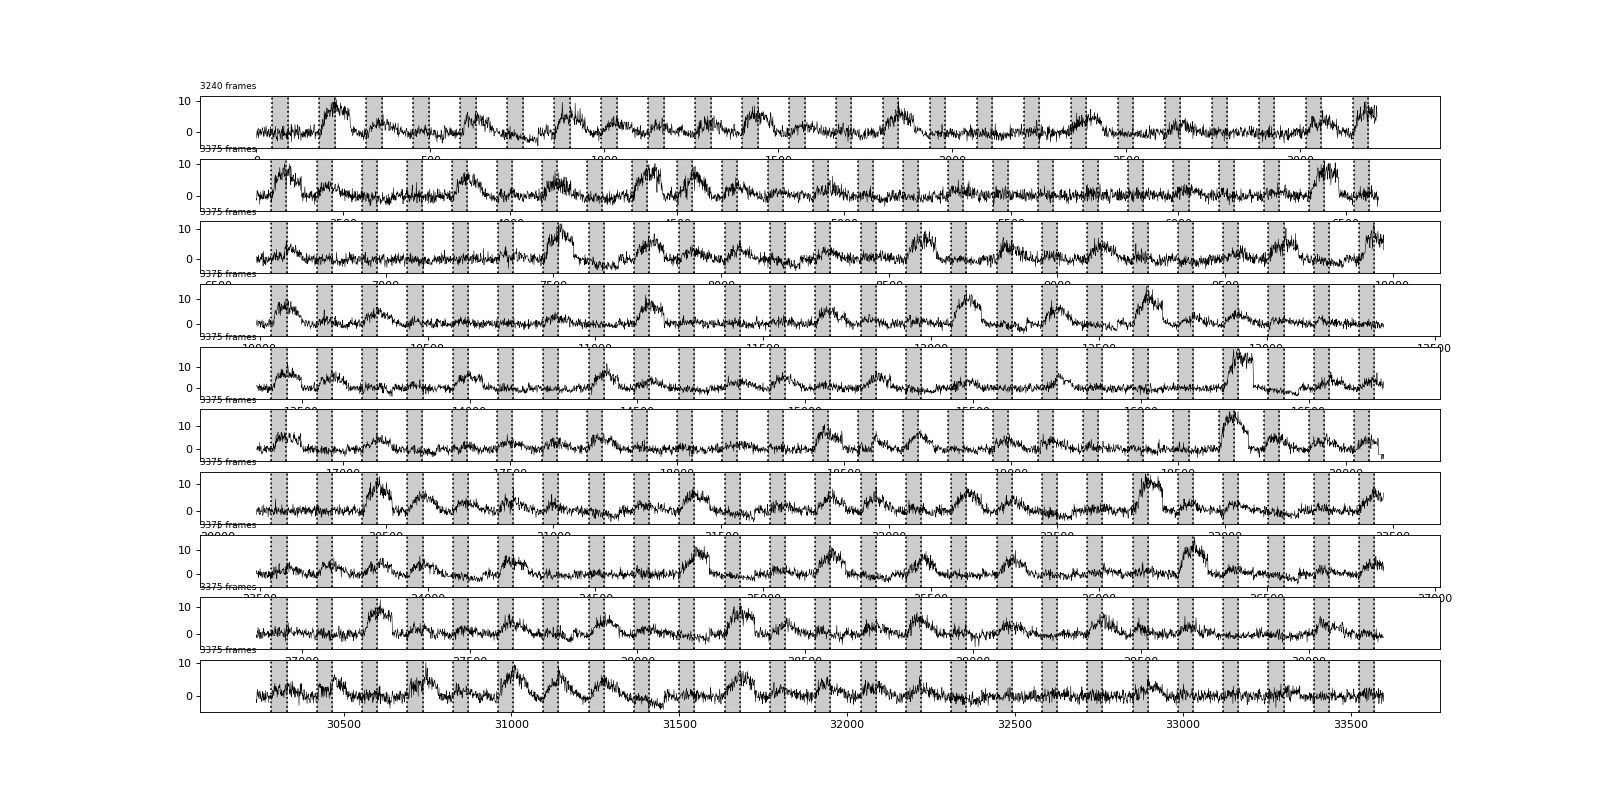

In [54]:
nframes_plot = 5000

nr = 10
fw = 20
fh = nr/2

fig, axn = pl.subplots(nr, 1, figsize=(fw, fh*2))
for ai, ((block_num, tifnun), g) in enumerate(labels.groupby(['run_ix', 'file_ix'])):
    if ai > nr-1:
        continue
    ax = axn[ai]
    ax.plot(g.index, zscored_traces[rid][g.index], lw=.5, color='k')
    ax.set_title('%i frames' % len(g.index), loc='left', fontsize=8)
    curr_stim_ons = [si for si in stim_on_ixs if g.index[0] <= si <= g.index[-1]]
    for si in curr_stim_ons:
        #if si < nframes_plot:
        ax.axvline(x=si, color='k', ls=':')
        ax.axvline(x=si+nframes_on, color='k', ls=':')
        ax.axvspan(si, si+nframes_on, color='k', alpha=0.2)

In [55]:
import h5py

In [56]:
from pipeline.python.paradigm.utils import get_rolling_baseline

In [59]:
# Get extracted traces
fov_dir = os.path.join(rootdir, animalid, session, fov)
rawfns = sorted(glob.glob(os.path.join(fov_dir, '*%s_*' % stimulus, 
                                       'traces', '%s*' % traceid, 'files', '*.hdf5')), key=putils.natural_keys)
print("Found %i raw file arrays." % len(rawfns))


Found 54 raw file arrays.


In [60]:
fpath = rawfns[0]
print(fpath)

/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/blobs_run1/traces/traces001_1621ed/files/File001_rawtraces_1621ed.hdf5


In [62]:
# Load raw traces from 1 tif
rfile = h5py.File(fpath, 'r')
fdata = rfile['Slice01'] # fdata['traces'].keys() are [u'neuropil', u'np_subtracted', u'raw']
df = pd.DataFrame(fdata['traces']['np_subtracted'][:])


In [65]:
# Detrend raw traces
window_size_sec = 30.
quantile = 0.10
framerate = run_info['framerate']
windowsize = window_size_sec*framerate

detrended_df, F0_df = get_rolling_baseline(df, windowsize, quantile=quantile)


('drift offset:', 71.013684944032349)


In [67]:
parsed_frames_fpath = glob.glob(os.path.join(fpath.split('/traces')[0], 'paradigm', 'parsed_frames_*.hdf5'))[0] #' in pfn][0]
print(parsed_frames_fpath)
parsed_frames = h5py.File(parsed_frames_fpath, 'r')

trial_list = sorted(parsed_frames.keys(), key=putils.natural_keys)
print "There are %i total trials across all .tif files." % len(trial_list)

stim_onset_idxs = np.array([pf['frames_in_file'].attrs['stim_on_idx'] \
                            for t, pf in parsed_frames.items()])


/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/blobs_run1/paradigm/parsed_frames_562664.hdf5
There are 249 total trials across all .tif files.


<IPython.core.display.Javascript object>


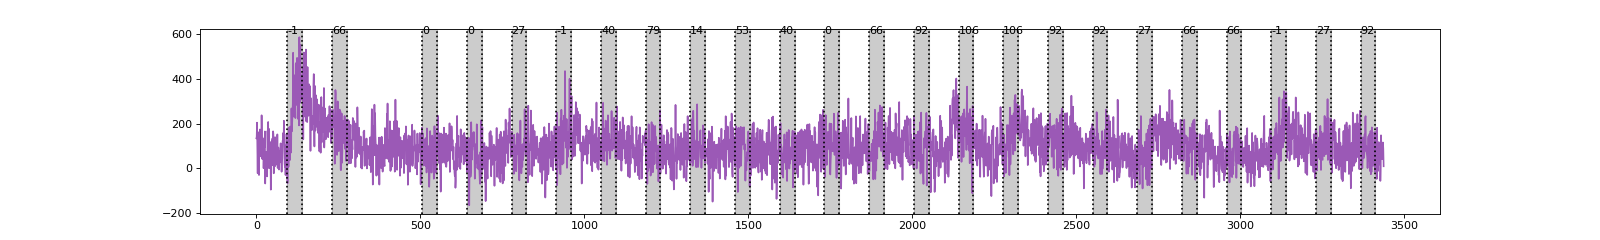

In [76]:
fig, ax = pl.subplots(figsize=(20,3))
ax.plot(detrended_df[rid])

curr_stim_ons = [si for si in stim_onset_idxs if detrended_df.index[0] <= si <= detrended_df.index[-1]]
for ti, si in enumerate(curr_stim_ons):
    #if si < nframes_plot:
    ax.axvline(x=si, color='k', ls=':')
    ax.axvline(x=si+nframes_on, color='k', ls=':')
    ax.axvspan(si, si+nframes_on, color='k', alpha=0.2)
    
    curr_cfg = labels[labels['trial']=='trial%05d' % int(ti+1)]['config'].unique()[0]
    
    curr_stim = sdf['morphlevel'][curr_cfg]
    ax.annotate('%i' % curr_stim, (si, 600))

In [91]:
[(t, sdf['morphlevel'][g['config'].unique()[0]]) for t, g in labels.groupby(['trial'])]


[(u'trial00001', -1),
 (u'trial00002', 66),
 (u'trial00003', 0),
 (u'trial00004', 0),
 (u'trial00005', 27),
 (u'trial00006', -1),
 (u'trial00007', 40),
 (u'trial00008', 79),
 (u'trial00009', 14),
 (u'trial00010', 53),
 (u'trial00011', 40),
 (u'trial00012', 0),
 (u'trial00013', 66),
 (u'trial00014', 92),
 (u'trial00015', 106),
 (u'trial00016', 106),
 (u'trial00017', 92),
 (u'trial00018', 92),
 (u'trial00019', 27),
 (u'trial00020', 66),
 (u'trial00021', 66),
 (u'trial00022', -1),
 (u'trial00023', 27),
 (u'trial00024', 92),
 (u'trial00025', 79),
 (u'trial00026', 0),
 (u'trial00027', 92),
 (u'trial00028', 53),
 (u'trial00029', 27),
 (u'trial00030', 106),
 (u'trial00031', 27),
 (u'trial00032', -1),
 (u'trial00033', 40),
 (u'trial00034', 14),
 (u'trial00035', 106),
 (u'trial00036', 106),
 (u'trial00037', 53),
 (u'trial00038', 79),
 (u'trial00039', -1),
 (u'trial00040', 40),
 (u'trial00041', 66),
 (u'trial00042', 40),
 (u'trial00043', 79),
 (u'trial00044', 0),
 (u'trial00045', 79),
 (u'trial0

In [93]:
rid

22

In [70]:
detrended_df.head()

0          1           2           3          4          5    \
0  42.817088  51.636091   67.929937   24.705043  -9.021129  42.730053   
1  44.809219 -31.025330  104.483601   90.616898  64.751689  20.337299   
2  -9.077793  14.991266   33.384581   31.621040  11.490755  93.617042   
3  11.847822  28.198211   41.551613   84.279729  28.565195  45.793595   
4  50.215240  86.393348   47.858373  122.938619 -10.653042  95.827136   

          6           7           8          9       ...            224  \
0   46.495539   52.175423  -10.172592  45.226687     ...      46.884977   
1   60.882533   12.299487  178.004624  54.307500     ...      63.579834   
2  121.809237   -7.383227   81.602064  52.472307     ...     -41.264733   
3    7.366027   90.129394  -55.731906  93.845145     ...     -29.026558   
4   63.470400  215.749976  102.922245  89.471966     ...      86.592208   

          225         226         227         228         229         230  \
0  124.664009  155.724470   77.936312  306.371561  146.236605  167.541536   
1   15.198329   81.811879  -18.770784  121.138252   84.960056  229.681863   
2  197.266425  141.708991  290.731640  171.541056   30.267626  320.619382   
3  215.938657  114.522070  -57.180868  190.811774  -85.818572  126.386109   
4  285.446375   93.968074  -24.334481   69.260596  127.796462   62.309974   

          231         232         233  
0   31.716014   46.064373  148.204904  
1  258.122207  219.995358  199.141179  
2  210.181417   36.427731   40.181112  
3   34.321162    0.487804  120.960346  
4  137.250270  -68.397938  112.749926  

[5 rows x 234 columns]

In [71]:
fpath

'/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/blobs_run1/traces/traces001_1621ed/files/File001_rawtraces_1621ed.hdf5'

In [72]:
stim_onset_idxs

array([   94,   230,   506,   642,   778,   915,  1051,  1187,  1323,
        1460,  1596,  1732,  1868,  2005,  2141,  2277,  2413,  2550,
        2686,  2822,  2958,  3095,  3231,  3367,  3532,  3668,  3805,
        3941,  4077,  4214,  4350,  4486,  4622,  4758,  4895,  5031,
        5167,  5303,  5440,  5576,  5712,  5849,  5985,  6121,  6257,
        6393,  6530,  6666,  6802,  6970,  7106,  7242,  7378,  7515,
        7651,  7787,  7924,  8060,  8196,  8332,  8469,  8605,  8741,
        8877,  9014,  9150,  9286,  9422,  9559,  9695,  9831,  9967,
       10103, 10240, 10408, 10544, 10681, 10817, 10953, 11089, 11226,
       11362, 11498, 11635, 11771, 11907, 12043, 12179, 12316, 12452,
       12588, 12724, 12861, 12997, 13133, 13269, 13406, 13542, 13678,
       13846, 13982, 14118, 14255, 14391, 14527, 14663, 14800, 14936,
       15072, 15208, 15345, 15481, 15617, 15754, 15890, 16026, 16162,
       16298, 16435, 16571, 16707, 16843, 16980, 17116, 17284, 17420,
       17556, 17693,